In [1]:
# Check if the notebook is run in google colab, if so, import some stuff
import sys
import os

colab = 'google.colab' in sys.modules

if colab:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    %cd /content/CryptoCrystalBall/JupyterDocker/notebooks

In [2]:
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

### Add custom import path for DataStreamCreator

In [5]:
# Get the current directory
current_dir = os.getcwd()
current_dir_splitted = current_dir.split(os.sep)
current_dir_splitted

['', 'home', 'jovyan', 'CryptoCrystalBall', 'JupyterDocker', 'notebooks']

In [6]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'DataStreamCreator')
print(f"dsc_dir: {dsc_dir}")

ind_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'IndicatorCalculator')
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /home/jovyan/CryptoCrystalBall/DataStreamCreator
ind_dir: /home/jovyan/CryptoCrystalBall/IndicatorCalculator


In [7]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

# Define all the parameters and variables

In [8]:
# Define the data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted[:-2], 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /home/jovyan/CryptoCrystalBall/DemoData


In [9]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted[:-2], 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /home/jovyan/CryptoCrystalBall/Documentation/Images


In [10]:
# Define a global random seed
RANDOM_SEED = 11

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [11]:
# Define the paths to two example OHLCV files
EXAMPLE_FILE_PATHS = [os.path.join(DATA_PATH, "BTC-USDT.csv"), os.path.join(DATA_PATH, "ETH-USDT.csv")]
EXAMPLE_FILE_PATHS

['/home/jovyan/CryptoCrystalBall/DemoData/BTC-USDT.csv',
 '/home/jovyan/CryptoCrystalBall/DemoData/ETH-USDT.csv']

In [12]:
X_BLOCK_LENGHT = 128
BATCH_SIZE = 32

In [13]:
SHORTSPAN = 6
MIDSPAN = 48
LONGSPAN = 120

# Demonstration of IndicatorCalculator

The IndicatorCalculation class is used to add financial indicators to a pandas table of OHLC(V) data.
It is based on the library "TA-Lib" (See Link https://mrjbq7.github.io/ta-lib/) 

The columns of the input table have to be named as following:
- open, high, low, close, volume; The timestamp is the index of the table.

Requried constructor arguments:
- `shortspan`: An `int` for calculting indicators over a short time period (--> fast changing indicators, e.g. 6)
- `midspan`: An `int` for calculting indicators over a middle time period (--> in-between changing indicators, e.g. 24)
- `longspan`: An `int` for calculting indicators over a long time period (--> slow changing indicators, e.g. 120)

Optional constructor arguments:
- `verbose`: A `bool` flag for activating printing of additional information, like table shapes. `False` by default.
- `dropna`: A `bool` flag if rows containing `NaN` values shall be dropped. `False` by default, `NaN`s are replaced by `0.0`.

In [14]:
# Load the OHLCV table
tickdata = pd.read_csv(EXAMPLE_FILE_PATHS[0])
tickdata.set_index("startsAt", inplace = True) # Todo: Take care of the index name
tickdata.sort_index()

# Let the table start at an interesting position (just for demonstration)
tickdata = tickdata.iloc[10000:,]

tickdata

open          high           low         close     volume  \
startsAt                                                                        
1485928800    975.655125    975.655125    975.655125    975.655125   0.000000   
1485932400    973.400000    973.400000    973.400000    973.400000   0.003092   
1485936000    973.400000    973.400000    973.400000    973.400000   0.000000   
1485939600    973.400000    973.400000    973.400000    973.400000   0.000000   
1485943200    962.000000    973.735000    954.849711    973.735000   0.140184   
...                  ...           ...           ...           ...        ...   
1627761600  41312.243514  41819.689357  41174.024002  41504.090831   6.954679   
1627765200  41532.010689  41974.904927  41532.010689  41960.070000   7.271290   
1627768800  41961.294435  41977.030664  41645.385796  41870.548474   6.137356   
1627772400  41838.657138  41942.798100  41324.944231  41448.430802  10.411857   
1627776000  41460.515600  41779.055816  41148.417800  41697.318684  18.597236   

              quoteVolume  
startsAt                   
1485928800       0.000000  
1485932400       3.009714  
1485936000       0.000000  
1485939600       0.000000  
1485943200     134.740802  
...                   ...  
1627761600  288855.157694  
1627765200  303437.038256  
1627768800  256691.373423  
1627772400  434411.360678  
1627776000  772063.318313  

[39403 rows x 6 columns]

In [15]:
# Initialize the an IndicatorCalculator instance
indicatorCalculator = IndicatorCalculator(shortspan=SHORTSPAN,
                                          midspan=MIDSPAN,
                                          longspan=LONGSPAN)

In [16]:
# Calculate the 'overlap' indicators on the OHLCV table --> These are the price-related ones
# For testing, the `MIDSPAN` timespan is used

overlapTable = indicatorCalculator.CalcOverlapTable(sourceTable=tickdata,
                                                    timeSpan=MIDSPAN)
overlapTable

c_BolL48      c_BolM48      c_BolU48      c_DEMA48  \
startsAt                                                             
1485928800      0.000000      0.000000      0.000000      0.000000   
1485932400      0.000000      0.000000      0.000000      0.000000   
1485936000      0.000000      0.000000      0.000000      0.000000   
1485939600      0.000000      0.000000      0.000000      0.000000   
1485943200      0.000000      0.000000      0.000000      0.000000   
...                  ...           ...           ...           ...   
1627761600  38203.339590  40522.038335  42840.737080  41610.650535   
1627765200  38235.601006  40572.244214  42908.887422  41671.357717   
1627768800  38261.734876  40615.697613  42969.660349  41720.532595   
1627772400  38285.924166  40645.293613  43004.663060  41732.269695   
1627776000  38313.725250  40682.255112  43050.784973  41762.498087   

                 c_EMA48  c_HT_TRENDLINE      c_KAMA48        c_MA48  \
startsAt                                                               
1485928800      0.000000        0.000000      0.000000      0.000000   
1485932400      0.000000        0.000000      0.000000      0.000000   
1485936000      0.000000        0.000000      0.000000      0.000000   
1485939600      0.000000        0.000000      0.000000      0.000000   
1485943200      0.000000        0.000000      0.000000      0.000000   
...                  ...             ...           ...           ...   
1627761600  40773.741944    41591.139798  40452.848435  40522.038335   
1627765200  40822.163497    41618.429890  40520.395932  40572.244214   
1627768800  40864.954720    41635.953475  40571.108067  40615.697613   
1627772400  40888.770071    41628.324273  40591.106701  40645.293613   
1627776000  40921.772055    41615.150923  40623.433372  40682.255112   

            c_MIDPOINT48  c_MIDPRICE48  c_SAR_0005_005  c_SAR_002_02  \
startsAt                                                               
1485928800      0.000000      0.000000        0.000000      0.000000   
1485932400      0.000000      0.000000      975.655125    975.655125   
1485936000      0.000000      0.000000      975.643850    975.610023   
1485939600      0.000000      0.000000      975.632630    975.565822   
1485943200      0.000000      0.000000      975.621467    975.522506   
...                  ...           ...             ...           ...   
1627761600  40417.077121  40364.312204    39455.636595  42180.265413   
1627765200  40417.077121  40364.312204    39499.802046  42135.658498   
1627768800  40417.077121  40364.312204    39543.305016  42092.835860   
1627772400  40417.077121  40364.312204    39586.155440  42051.726127   
1627776000  40417.077121  40364.312204    39628.363109  42012.260784   

                 c_SMA48      c_TEMA48     c_TRIMA48       c_WMA48  
startsAt                                                            
1485928800      0.000000      0.000000      0.000000      0.000000  
1485932400      0.000000      0.000000      0.000000      0.000000  
1485936000      0.000000      0.000000      0.000000      0.000000  
1485939600      0.000000      0.000000      0.000000      0.000000  
1485943200      0.000000      0.000000      0.000000      0.000000  
...                  ...           ...           ...           ...  
1627761600  40522.038335  41684.211395  40499.683677  40999.878131  
1627765200  40572.244214  41753.700268  40586.960144  41058.573301  
1627768800  40615.697613  41805.637323  40672.421361  41111.565311  
1627772400  40645.293613  41802.315499  40754.016554  41145.554421  
1627776000  40682.255112  41827.024496  40831.671407  41188.494220  

[39403 rows x 16 columns]

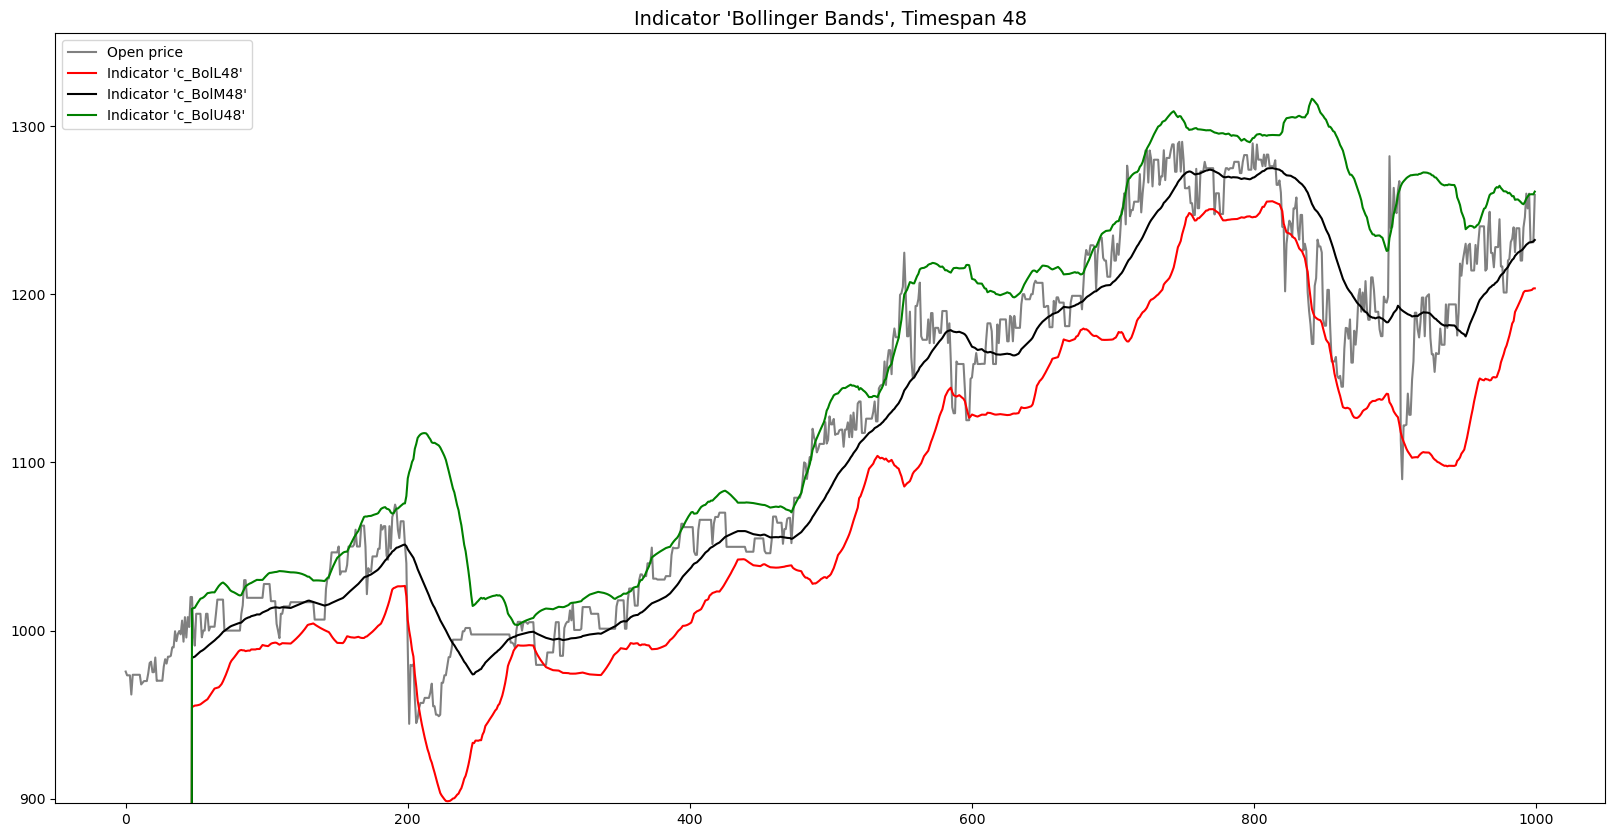

In [17]:
# Plot the Bollinger Band indicators as example
chart_name="Indicator 'Bollinger Bands', Timespan 48"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

x_len = 1000

# Plot the 'baseline'
ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

# Plot the indicators
ax1.plot(overlapTable.loc[:,'c_BolL48'].values[:x_len], color="red", label="Indicator 'c_BolL48'")
ax1.plot(overlapTable.loc[:,'c_BolM48'].values[:x_len], color="black", label="Indicator 'c_BolM48'")
ax1.plot(overlapTable.loc[:,'c_BolU48'].values[:x_len], color="green", label="Indicator 'c_BolU48'")

# Set min/max based on open price, as the indicators are 0 at the beginning
# This is because they would have been nan, and therefore are set to 0
MIN_MAX_FACTOR = 0.05
minValue = np.min(tickdata.loc[:,'open'].values[:x_len]) * (1.0 - MIN_MAX_FACTOR)
maxValue = np.max(tickdata.loc[:,'open'].values[:x_len]) * (1.0 + MIN_MAX_FACTOR)
ax1.set_ylim(minValue, maxValue)

# Show a legend
plt.legend(loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [18]:
indicatorTableColumns = list(overlapTable.columns)
indicatorTableColumns

['c_BolL48',
 'c_BolM48',
 'c_BolU48',
 'c_DEMA48',
 'c_EMA48',
 'c_HT_TRENDLINE',
 'c_KAMA48',
 'c_MA48',
 'c_MIDPOINT48',
 'c_MIDPRICE48',
 'c_SAR_0005_005',
 'c_SAR_002_02',
 'c_SMA48',
 'c_TEMA48',
 'c_TRIMA48',
 'c_WMA48']

In [19]:
chartColumns = int(np.max([4, np.ceil(np.sqrt(len(indicatorTableColumns)))]))
chartColumns

4

In [20]:
chartRows = int(np.ceil(len(indicatorTableColumns)/chartColumns))
chartRows

4

In [21]:
def PlotIndicatorOverview(indicatorType, indiTbl, tickTbl):
    indicatorTableColumns = sorted(list(indiTbl.columns))

    chartColumns = int(np.min([3, np.ceil(np.sqrt(len(indicatorTableColumns)))]))
    chartRows = int(np.ceil(len(indicatorTableColumns)/chartColumns))
    i = 0

    x_len = 1000

    chart_name=f"Overview of {indicatorType}"
    fig, axs = plt.subplots(chartRows, chartColumns,figsize=(7*chartColumns,3*chartRows))
    fig.subplots_adjust(wspace=0.05, hspace=0.1)

    fig.suptitle(chart_name, fontsize=14, y=0.91)

    # Set min/max based on open price, as the indicators are 0 at the beginning
    # This is because they would have been nan, and therefore are set to 0
    MIN_MAX_FACTOR = 0.05
    minValue = np.min(tickTbl.loc[:,'open'].values[:x_len]) * (1.0 - MIN_MAX_FACTOR)
    maxValue = np.max(tickTbl.loc[:,'open'].values[:x_len]) * (1.0 + MIN_MAX_FACTOR)

    for nR in range(chartRows):
        for nC in range(chartColumns):
            # Hide unused charts
            if len(indicatorTableColumns) == i:
                axs[nR, nC].set_axis_off()
                continue

            # Get the indicator name
            indiName = indicatorTableColumns[i]

            # Set the title
            axs[nR, nC].set_title(f"{indiName}", y=1.0, pad=-14)

            # Plot the 'baseline'
            axs[nR, nC].plot(tickTbl.loc[:,'open'].values[:x_len], color="gray", label="Open price")
            
            # Plot price-related indicators (identified by 'c_' on the left axis, the others on the right)
            if 'c_' == indiName[:2]:
                indicatorAxis = axs[nR, nC]
            else:
                indicatorAxis = axs[nR, nC].twinx()

            # Plot the indicator
            indicatorAxis.plot(indiTbl.loc[:,indiName].values[:x_len], color="red", label="Indicator '{indiName}'")

            # Set y min max
            axs[nR, nC].set_ylim(minValue, maxValue)

            i+=1

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    # Save the figure
    fig_name = chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
    fig_name = "Indicators_" + fig_name
    plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

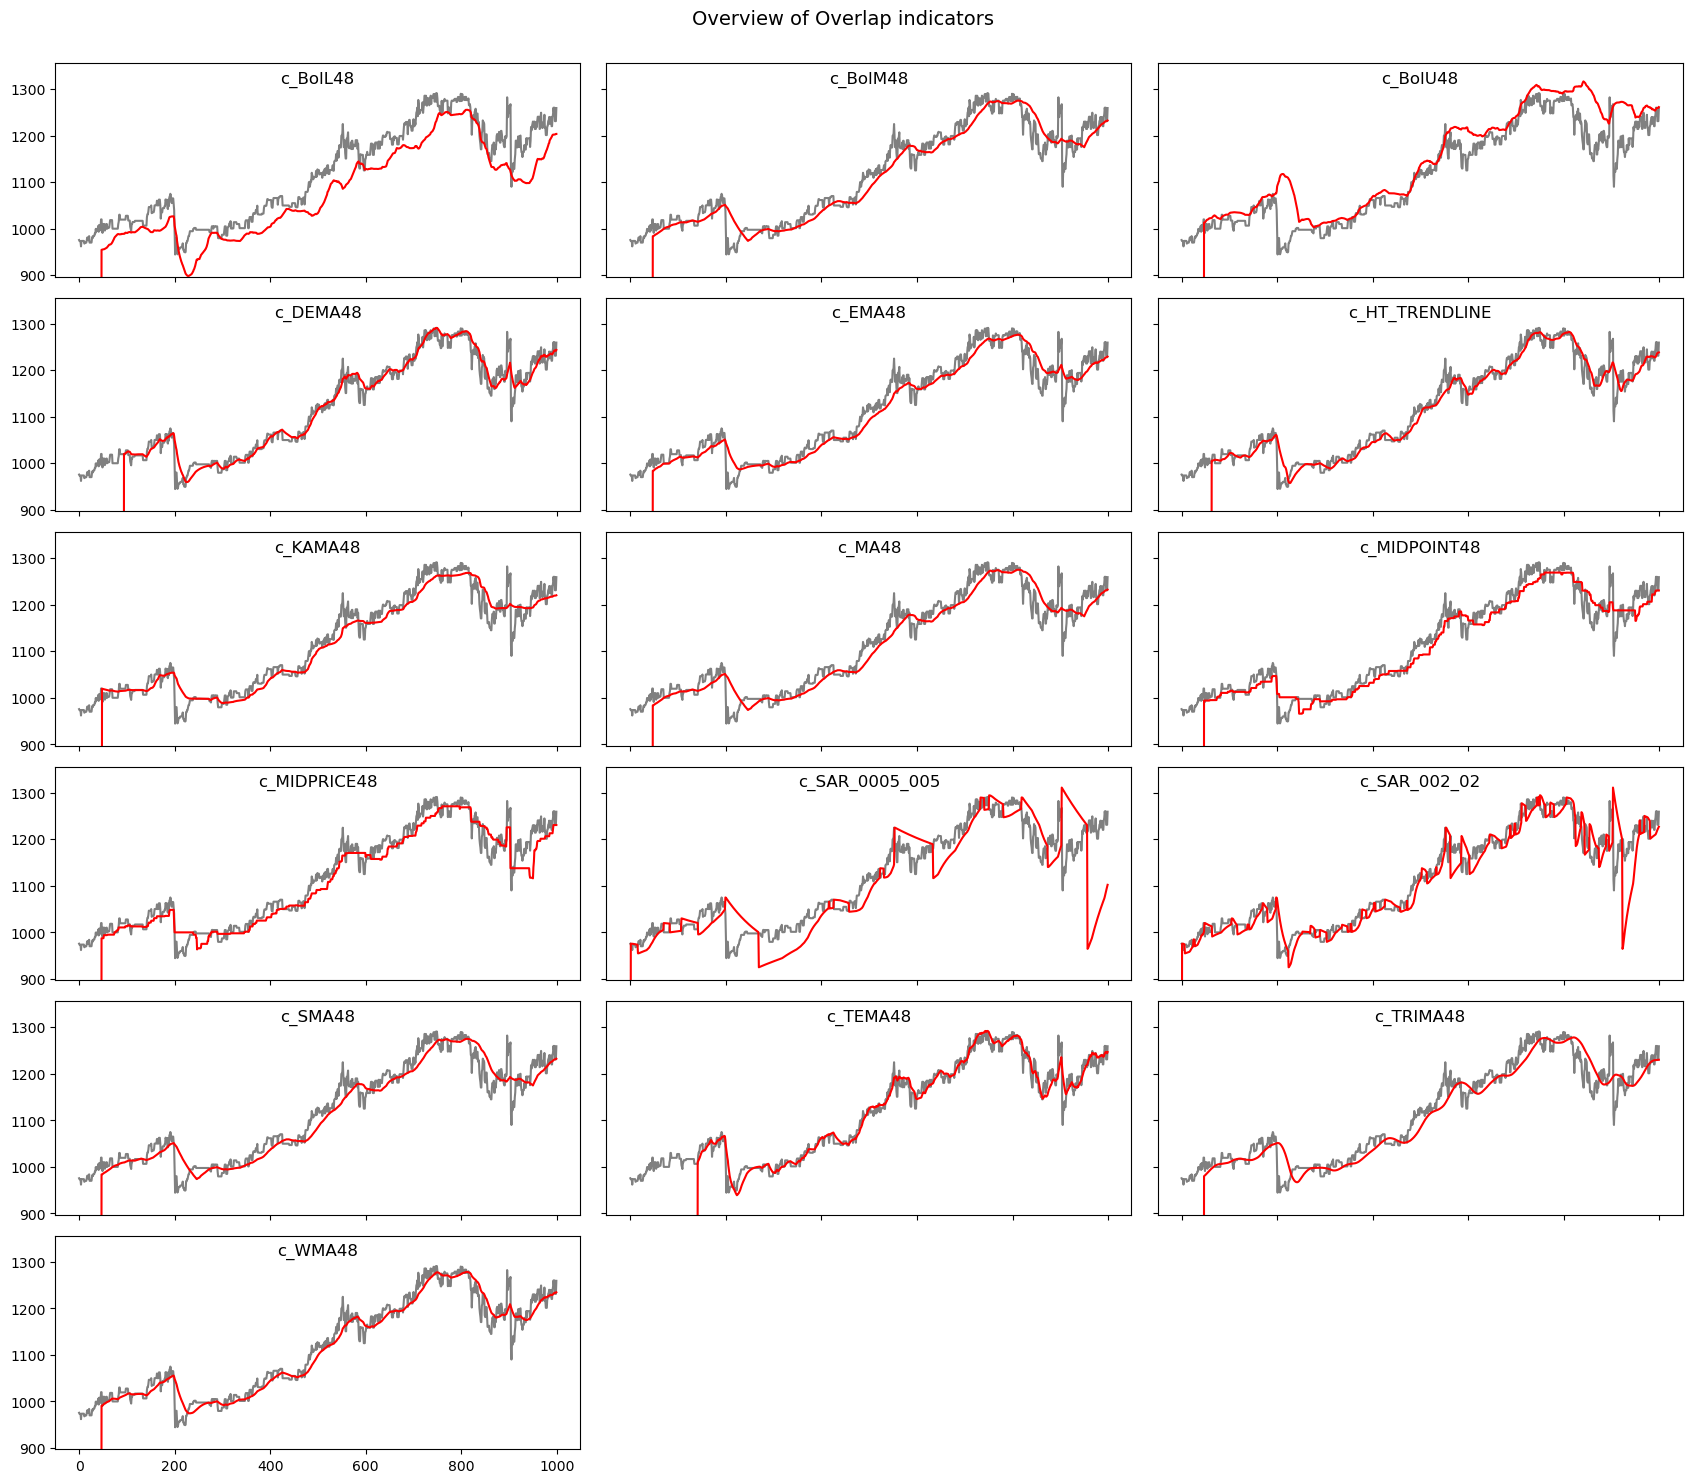

In [22]:
# Plot all overlap indicators
PlotIndicatorOverview("Overlap indicators", overlapTable, tickdata)

## Momentum indicators

In [23]:
# Calculate the 'momentum' indicators on the OHLCV table
# For testing, the `MIDSPAN` timespan is used

momentumTable = indicatorCalculator.CalcMomentumTable(sourceTable=tickdata,
                                                    timeSpan=MIDSPAN)
momentumTable

ADX48     ADXR48   APO_12_26  AROONDOWN48  AROONOSC48  \
startsAt                                                                
1485928800   0.000000   0.000000    0.000000     0.000000        0.00   
1485932400   0.000000   0.000000    0.000000     0.000000        0.00   
1485936000   0.000000   0.000000    0.000000     0.000000        0.00   
1485939600   0.000000   0.000000    0.000000     0.000000        0.00   
1485943200   0.000000   0.000000    0.000000     0.000000        0.00   
...               ...        ...         ...          ...         ...   
1627761600  21.226325  22.985622  -18.870330    27.083333       31.25   
1627765200  21.272672  22.883595  -71.983025    25.000000       31.25   
1627768800  21.318420  22.838088 -112.774530    22.916667       31.25   
1627772400  21.275344  22.745924 -137.523684    20.833333       31.25   
1627776000  21.186318  22.633565 -145.823322    18.750000       31.25   

            AROONUP48       BOP      CCI48      CMO48       DX48  ...  \
startsAt                                                          ...   
1485928800   0.000000  0.000000   0.000000   0.000000   0.000000  ...   
1485932400   0.000000  0.000000   0.000000   0.000000   0.000000  ...   
1485936000   0.000000  0.000000   0.000000   0.000000   0.000000  ...   
1485939600   0.000000  0.000000   0.000000   0.000000   0.000000  ...   
1485943200   0.000000  0.621383   0.000000   0.000000   0.000000  ...   
...               ...       ...        ...        ...        ...  ...   
1627761600  58.333333  0.297131  61.012054  15.269694  22.172320  ...   
1627765200  56.250000  0.966505  77.831780  18.864853  23.450989  ...   
1627768800  54.166667 -0.273624  75.413963  17.862134  23.468576  ...   
1627772400  52.083333 -0.631584  57.370813  13.261091  19.250778  ...   
1627776000  50.000000  0.375498  53.587873  15.253226  17.002101  ...   

               ROC48    ROCP48    ROCR48      RSI48      SLOWD      SLOWK  \
startsAt                                                                    
1485928800  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1485932400  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1485936000  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1485939600  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1485943200  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
...              ...       ...       ...        ...        ...        ...   
1627761600  4.524582  0.045246  1.045246  57.634847  46.928670  47.249129   
1627765200  6.093226  0.060932  1.060932  59.432427  48.097897  50.451057   
1627768800  5.242615  0.052426  1.052426  58.931067  49.720073  51.460033   
1627772400  3.549051  0.035491  1.035491  56.630545  50.802107  50.495230   
1627776000  4.443916  0.044439  1.044439  57.626613  50.930586  50.836496   

              TRIX48  ULTOSC_7_14_28    WILLR48    v_MFI48  
startsAt                                                    
1485928800  0.000000        0.000000   0.000000   0.000000  
1485932400  0.000000        0.000000   0.000000   0.000000  
1485936000  0.000000        0.000000   0.000000   0.000000  
1485939600  0.000000        0.000000   0.000000   0.000000  
1485943200  0.000000        0.000000   0.000000   0.000000  
...              ...             ...        ...        ...  
1627761600  0.082989       49.088956 -22.005073  68.810827  
1627765200  0.083301       54.061673 -10.805439  70.088881  
1627768800  0.083625       53.862015 -13.004242  70.249936  
1627772400  0.083878       52.100541 -23.372179  67.684671  
1627776000  0.084106       58.098302 -17.259064  66.630197  

[39403 rows x 33 columns]

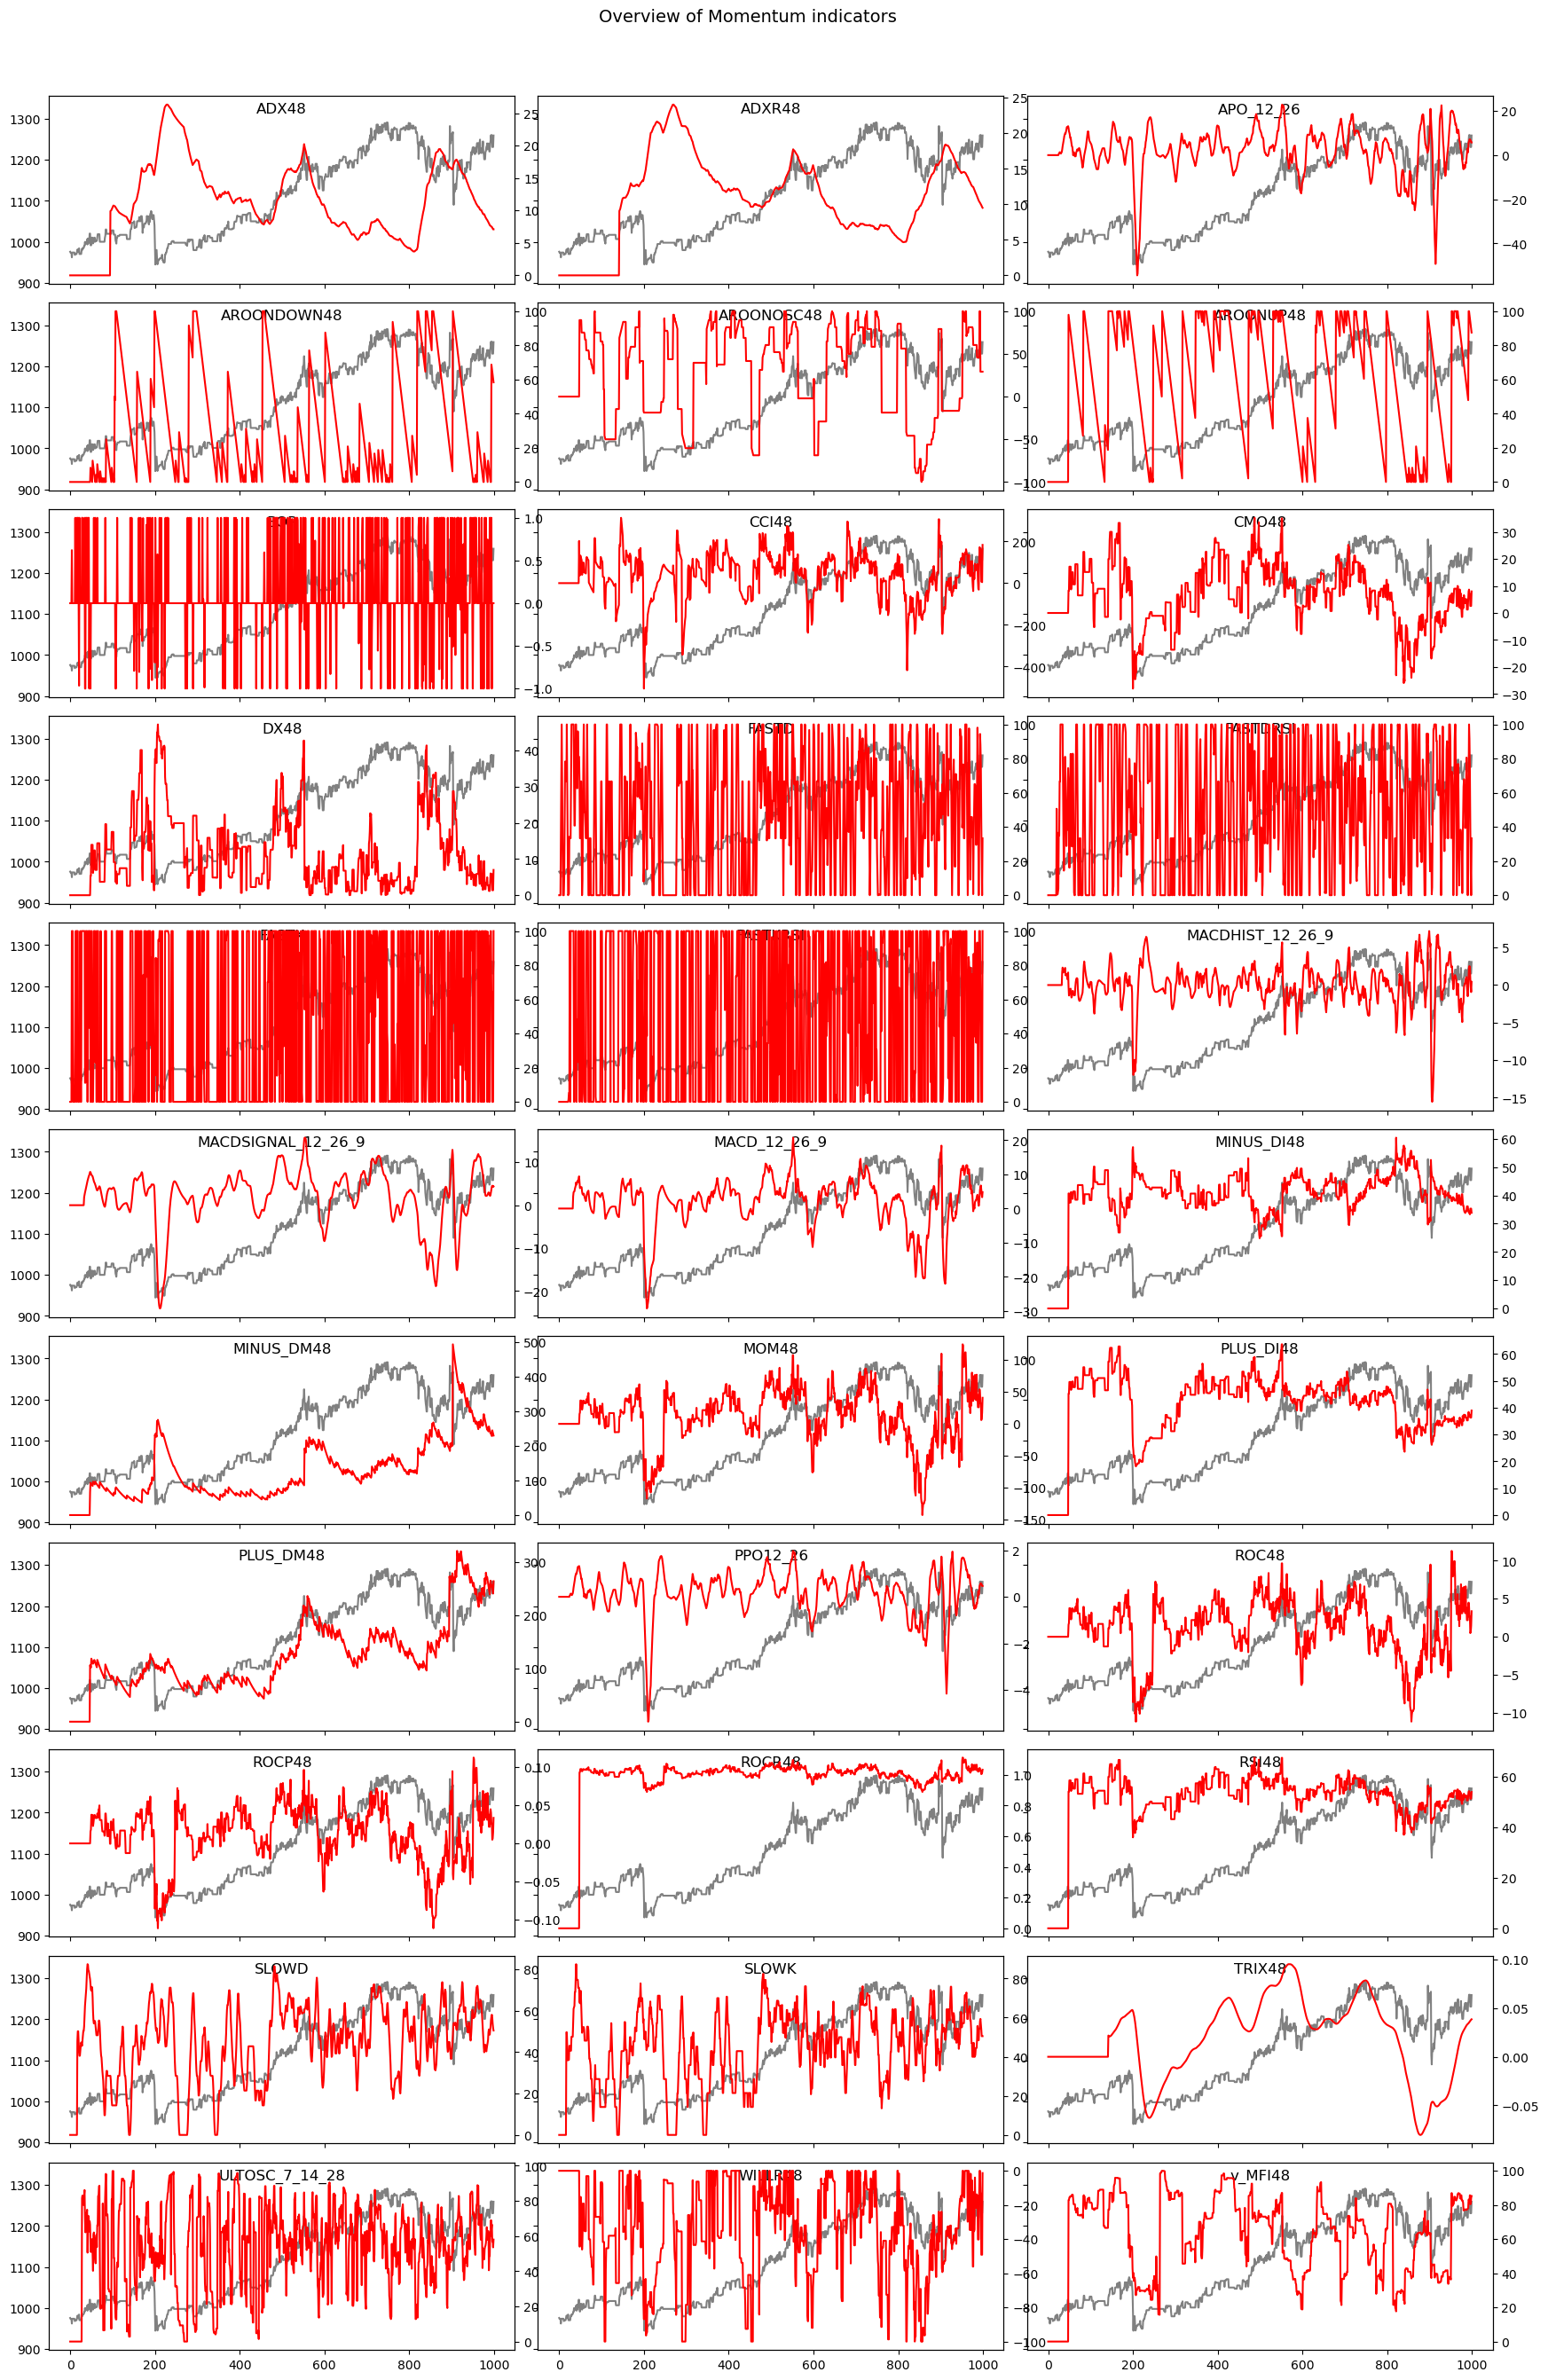

In [24]:
# Plot all indicators
PlotIndicatorOverview("Momentum indicators", momentumTable, tickdata)

## Volatility indicators

In [25]:
# Calculate the 'volatility' indicators on the OHLCV table
# For testing, the `MIDSPAN` timespan is used

volyTable = indicatorCalculator.CalcVolyTable(sourceTable=tickdata,
                                                    timeSpan=MIDSPAN)
volyTable

ATR48    NATR48      TRANGE
startsAt                                    
1485928800    0.000000  0.000000    0.000000
1485932400    0.000000  0.000000    2.255125
1485936000    0.000000  0.000000    0.000000
1485939600    0.000000  0.000000    0.000000
1485943200    0.000000  0.000000   18.885289
...                ...       ...         ...
1627761600  466.312628  1.123534  645.665354
1627765200  466.406409  1.111548  470.814096
1627768800  463.598877  1.107219  331.644868
1627772400  466.812523  1.126249  617.853869
1627776000  470.225554  1.127712  630.638016

[39403 rows x 3 columns]

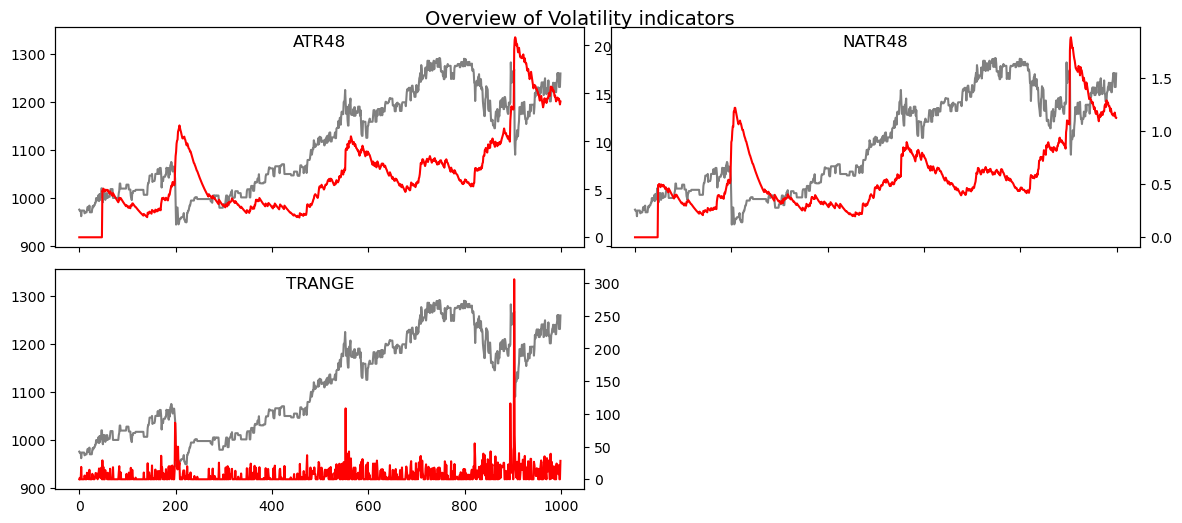

In [26]:
# Plot all indicators
PlotIndicatorOverview("Volatility indicators", volyTable, tickdata)

## Cyclic Indicators

In [27]:
# Calculate the 'cyclic' indicators on the OHLCV table
# These indicator do not require a timespan

cycTable = indicatorCalculator.CalcCycTable(sourceTable=tickdata)
cycTable

HT_DCPERIOD  HT_DCPHASE  HT_TRENDMODE     INPHASE  LEADSINE  \
startsAt                                                                  
1485928800     0.000000    0.000000             0    0.000000  0.000000   
1485932400     0.000000    0.000000             0    0.000000  0.000000   
1485936000     0.000000    0.000000             0    0.000000  0.000000   
1485939600     0.000000    0.000000             0    0.000000  0.000000   
1485943200     0.000000    0.000000             0    0.000000  0.000000   
...                 ...         ...           ...         ...       ...   
1627761600    23.225830  -23.444492             0 -175.454957  0.367402   
1627765200    23.452744    5.154931             0 -156.844170  0.767780   
1627768800    23.542663   16.353184             0 -276.851503  0.877592   
1627772400    23.466960   38.150407             0 -110.825054  0.992863   
1627776000    23.294032   49.190365             0   35.818033  0.997327   

            QUADRATURE      SINE  
startsAt                          
1485928800    0.000000  0.000000  
1485932400    0.000000  0.000000  
1485936000    0.000000  0.000000  
1485939600    0.000000  0.000000  
1485943200    0.000000  0.000000  
...                ...       ...  
1627761600  220.418342 -0.397860  
1627765200  -84.242303  0.089849  
1627768800  175.001535  0.281558  
1627772400  574.265206  0.617728  
1627776000  541.357652  0.756885  

[39403 rows x 7 columns]

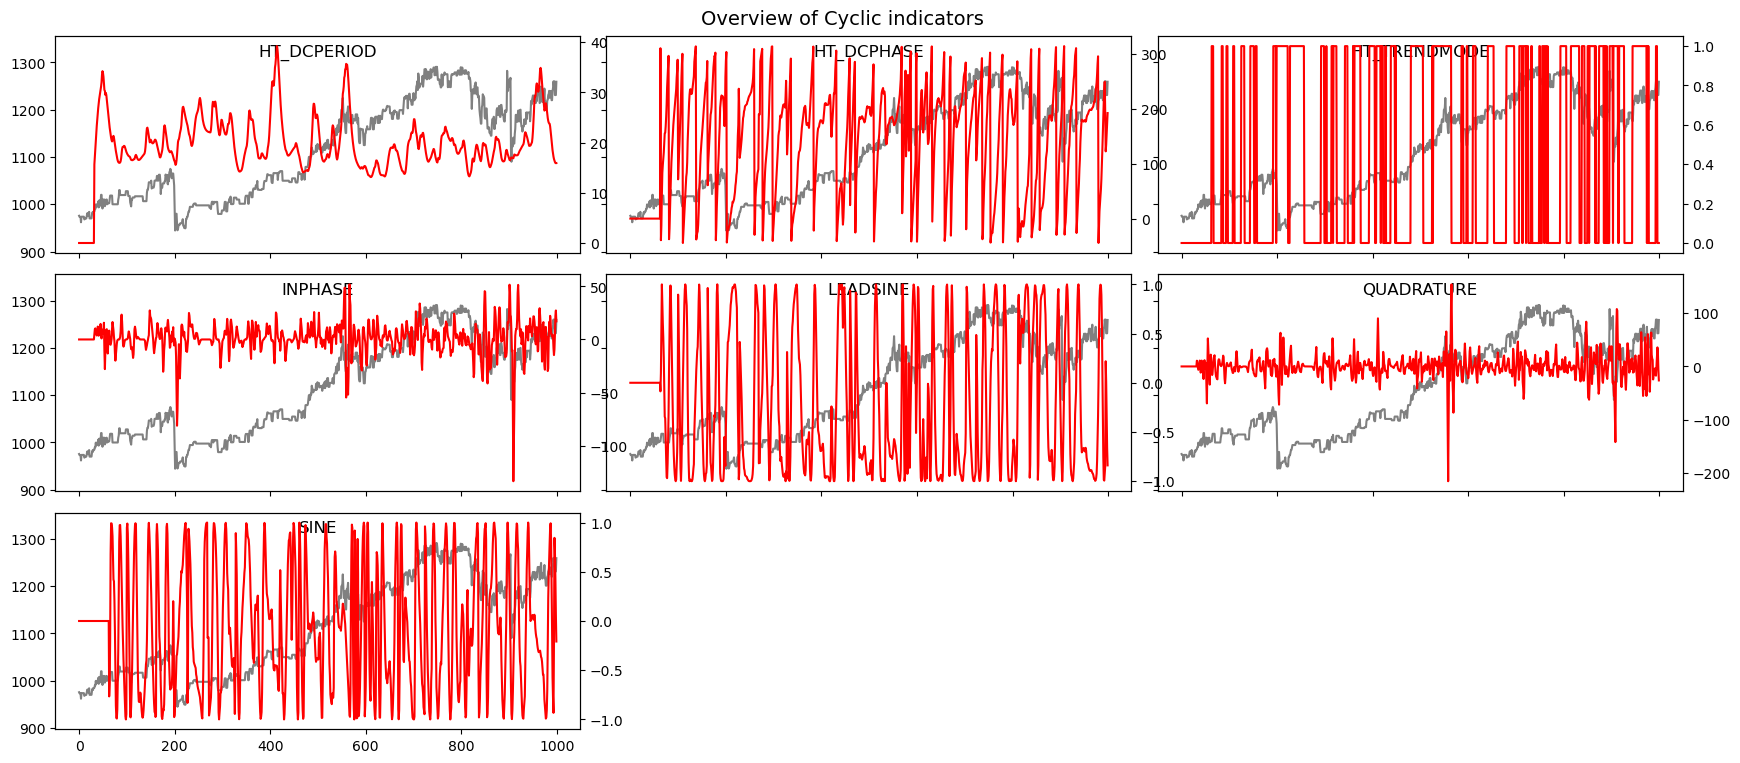

In [28]:
# Plot all indicators
PlotIndicatorOverview("Cyclic indicators", cycTable, tickdata)

## Statistical Indicators

In [29]:
# Calculate the 'statisitical' indicators on the OHLCV table
# For testing, the `MIDSPAN` timespan is used

statTable = indicatorCalculator.CalcStatTable(sourceTable=tickdata,
                                                    timeSpan=MIDSPAN)
statTable

BETA48  CORREL48  LINEARREG_ANGLE48  LINEARREG_SLOPE48  \
startsAt                                                               
1485928800  0.000000  0.000000           0.000000           0.000000   
1485932400  0.000000  0.000000           0.000000           0.000000   
1485936000  0.000000  0.000000           0.000000           0.000000   
1485939600  0.000000  0.000000           0.000000           0.000000   
1485943200  0.000000  0.000000           0.000000           0.000000   
...              ...       ...                ...                ...   
1627761600  0.350411  0.966795          89.060822          61.000825   
1627765200  0.353085  0.967345          89.077213          62.084564   
1627768800  0.352526  0.967719          89.094961          63.302259   
1627772400  0.353294  0.968151          89.102907          63.863082   
1627776000  0.360257  0.968056          89.113500          64.626269   

               STDDEV48         VAR48  c_LINEARREG48  c_LINEARREG_INTERCEPT48  \
startsAt                                                                        
1485928800     0.000000  0.000000e+00       0.000000                 0.000000   
1485932400     0.000000  0.000000e+00       0.000000                 0.000000   
1485936000     0.000000  0.000000e+00       0.000000                 0.000000   
1485939600     0.000000  0.000000e+00       0.000000                 0.000000   
1485943200     0.000000  0.000000e+00       0.000000                 0.000000   
...                 ...           ...            ...                      ...   
1627761600  1159.349372  1.344091e+06   41955.557721             39088.518949   
1627765200  1168.321604  1.364975e+06   42031.231473             39113.256956   
1627768800  1176.981368  1.385285e+06   42103.300708             39128.094517   
1627772400  1179.684723  1.391656e+06   42146.076038             39144.511188   
1627776000  1184.264931  1.402483e+06   42200.972436             39163.537787   

                 c_TSF48  
startsAt                  
1485928800      0.000000  
1485932400      0.000000  
1485936000      0.000000  
1485939600      0.000000  
1485943200      0.000000  
...                  ...  
1627761600  42016.558546  
1627765200  42093.316037  
1627768800  42166.602968  
1627772400  42209.939120  
1627776000  42265.598705  

[39403 rows x 9 columns]

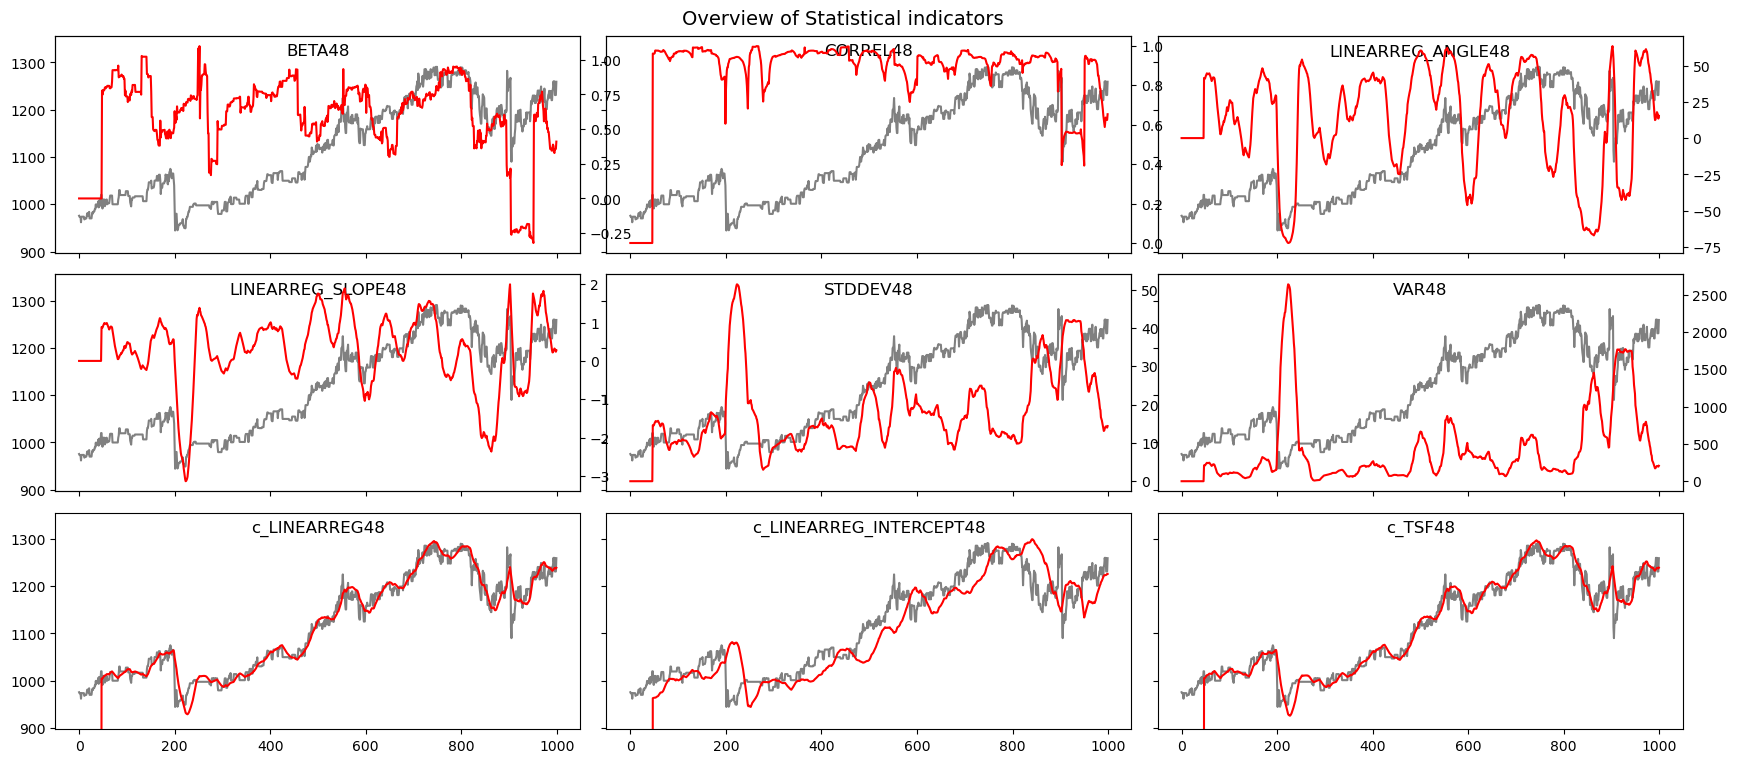

In [30]:
# Plot all indicators
PlotIndicatorOverview("Statistical indicators", statTable, tickdata)

## Volume Indicators

In [31]:
# Calculate the 'volume' indicators on the OHLCV table
# This method requires all three timespans

volTable = indicatorCalculator.CalcVolTable(sourceTable=tickdata,
                                              timeSpanShort=SHORTSPAN,
                                              timeSpanMiddle=MIDSPAN,
                                              timeSpanLong=LONGSPAN)

volTable

v_AD  v_ADOSC_48_120  v_ADOSC_6_120  v_ADOSC_6_48  \
startsAt                                                                 
1485928800       0.000000        0.000000       0.000000      0.000000   
1485932400       0.000000        0.000000       0.000000      0.000000   
1485936000       0.000000        0.000000       0.000000      0.000000   
1485939600       0.000000        0.000000       0.000000      0.000000   
1485943200       0.140184        0.000000       0.000000      0.000000   
...                   ...             ...            ...           ...   
1627761600  120125.295601       13.484333      26.308420     12.824087   
1627765200  120132.079781       13.708478      27.376053     13.667576   
1627768800  120134.276060       13.964013      28.587965     14.623951   
1627772400  120128.026107       14.043852      27.621904     13.578052   
1627776000  120141.802560       14.444285      30.521239     16.076954   

                   v_OBV  
startsAt                  
1485928800      0.000000  
1485932400     -0.003092  
1485936000     -0.003092  
1485939600     -0.003092  
1485943200      0.137092  
...                  ...  
1627761600 -23615.390198  
1627765200 -23608.118908  
1627768800 -23614.256264  
1627772400 -23624.668121  
1627776000 -23606.070885  

[39403 rows x 5 columns]

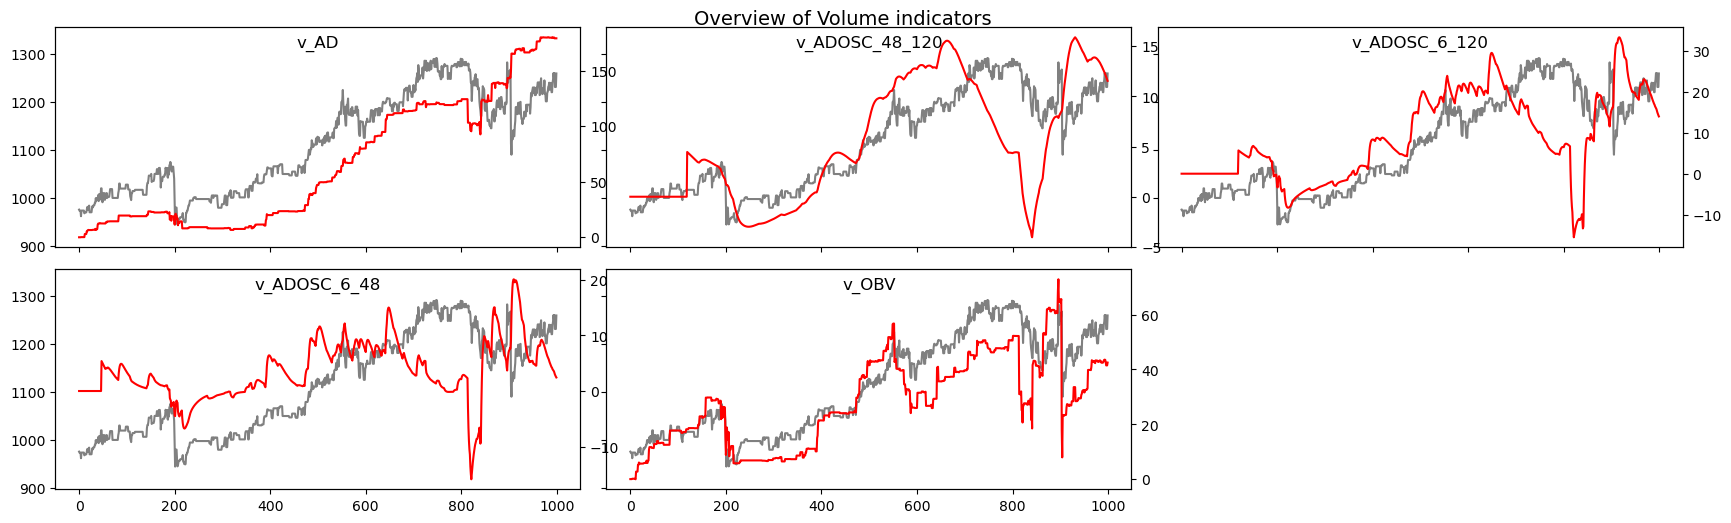

In [32]:
# Plot all indicators
PlotIndicatorOverview("Volume indicators", volTable, tickdata)

## Candle Pattern Indicators

In [33]:
# Calculate the 'candle pattern' indicators on the OHLCV table
# This method does not require a timespan

patternTable = indicatorCalculator.CalcPatternTable(sourceTable=tickdata)

patternTable

pat_cdl2crows  pat_cdl3blackcrows  pat_cdl3inside  \
startsAt                                                        
1485928800            0.0                 0.0             0.0   
1485932400            0.0                 0.0             0.0   
1485936000            0.0                 0.0             0.0   
1485939600            0.0                 0.0             0.0   
1485943200            0.0                 0.0             0.0   
...                   ...                 ...             ...   
1627761600            0.0                 0.0             0.0   
1627765200            0.0                 0.0             0.0   
1627768800            0.0                 0.0             0.0   
1627772400            0.0                 0.0             0.0   
1627776000            0.0                 0.0             0.0   

            pat_cdl3linestrike  pat_cdl3outside  pat_cdl3starsinsouth  \
startsAt                                                                
1485928800                 0.0              0.0                   0.0   
1485932400                 0.0              0.0                   0.0   
1485936000                 0.0              0.0                   0.0   
1485939600                 0.0              0.0                   0.0   
1485943200                 0.0              0.0                   0.0   
...                        ...              ...                   ...   
1627761600                 0.0              0.0                   0.0   
1627765200                 0.0              1.0                   0.0   
1627768800                 0.0              0.0                   0.0   
1627772400                 0.0              0.0                   0.0   
1627776000                 0.0              0.0                   0.0   

            pat_cdl3whitesoldiers  pat_cdlabandonedbaby  pat_cdladvanceblock  \
startsAt                                                                       
1485928800                    0.0                   0.0                  0.0   
1485932400                    0.0                   0.0                  0.0   
1485936000                    0.0                   0.0                  0.0   
1485939600                    0.0                   0.0                  0.0   
1485943200                    0.0                   0.0                  0.0   
...                           ...                   ...                  ...   
1627761600                    0.0                   0.0                  0.0   
1627765200                    0.0                   0.0                  0.0   
1627768800                    0.0                   0.0                  0.0   
1627772400                    0.0                   0.0                  0.0   
1627776000                    0.0                   0.0                  0.0   

            pat_cdlbelthold  ...  pat_cdlspinningtop  pat_cdlstalledpattern  \
startsAt                     ...                                              
1485928800              0.0  ...                 0.0                    0.0   
1485932400              0.0  ...                 0.0                    0.0   
1485936000              0.0  ...                 0.0                    0.0   
1485939600              0.0  ...                 0.0                    0.0   
1485943200              0.0  ...                 0.0                    0.0   
...                     ...  ...                 ...                    ...   
1627761600              0.0  ...                 0.0                    0.0   
1627765200              1.0  ...                 0.0                    0.0   
1627768800              0.0  ...                 0.0                    0.0   
1627772400              0.0  ...                 0.0                    0.0   
1627776000              0.0  ...                 0.0                    0.0   

            pat_cdlsticksandwich  pat_cdltakuri  pat_cdltasukigap  \
startsAt                                                            
148592880

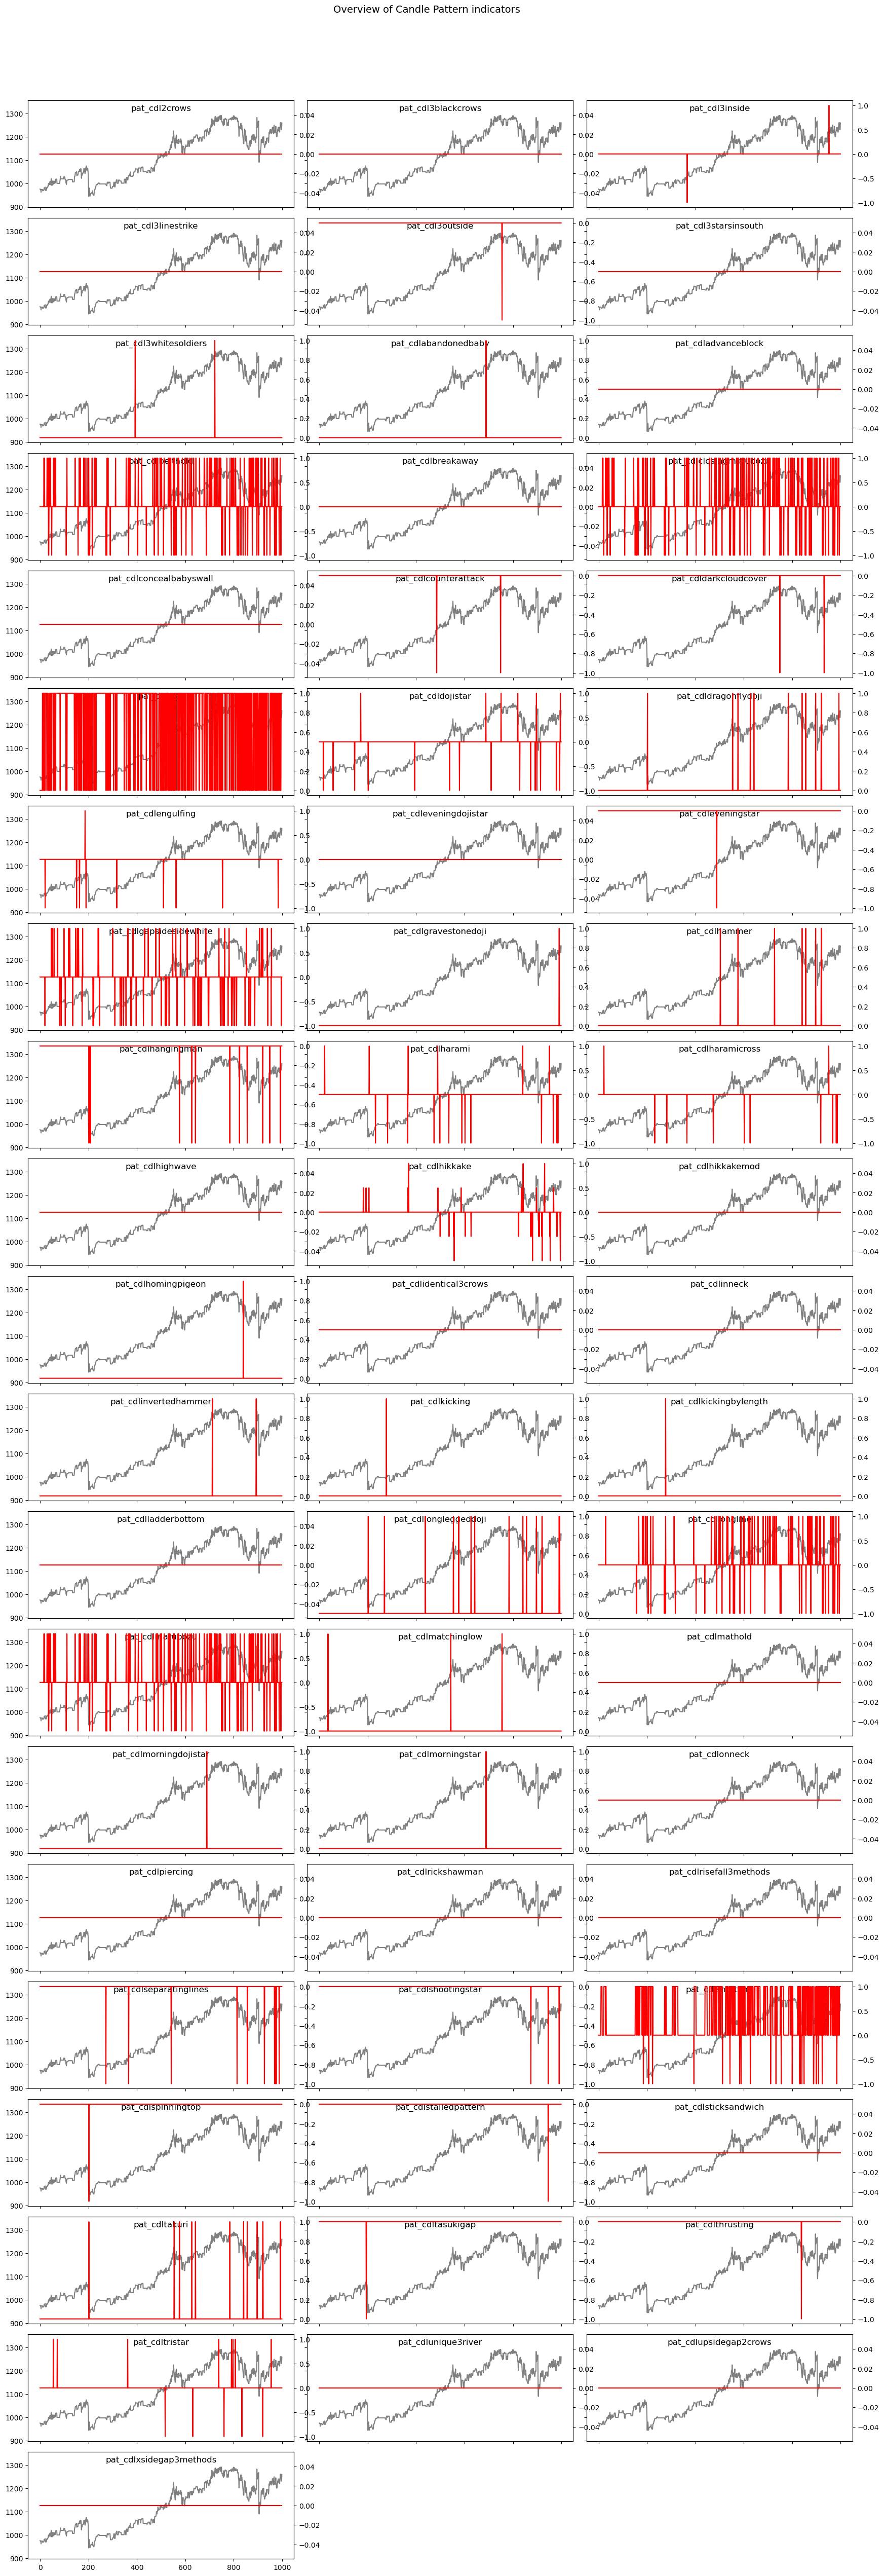

In [34]:
# Plot all indicators
PlotIndicatorOverview("Candle Pattern indicators", patternTable, tickdata)

## Create all available indicators

In [35]:
# Calculate all indicators on the OHLCV table

allIndicatorTable = indicatorCalculator.CreateAllIndicatorsTable(sourceTable=tickdata)
allIndicatorTable

ADX120      ADX48       ADX6    ADXR120     ADXR48      ADXR6  \
startsAt                                                                       
1485928800   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1485932400   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1485936000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1485939600   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1485943200   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
...               ...        ...        ...        ...        ...        ...   
1627761600  19.691923  21.226325  21.440073  17.992072  22.985622  24.090039   
1627765200  19.713140  21.272672  24.581100  18.043155  22.883595  24.178479   
1627768800  19.734240  21.318420  27.226605  18.094931  22.838088  26.064790   
1627772400  19.740983  21.275344  23.838384  18.134478  22.745924  23.920733   
1627776000  19.739960  21.186318  23.842828  18.164505  22.633565  21.993439   

             APO_12_26  AROONDOWN120  AROONDOWN48  AROONDOWN6  ...  \
startsAt                                                       ...   
1485928800    0.000000      0.000000     0.000000    0.000000  ...   
1485932400    0.000000      0.000000     0.000000    0.000000  ...   
1485936000    0.000000      0.000000     0.000000    0.000000  ...   
1485939600    0.000000      0.000000     0.000000    0.000000  ...   
1485943200    0.000000      0.000000     0.000000    0.000000  ...   
...                ...           ...          ...         ...  ...   
1627761600  -18.870330      5.833333    27.083333   50.000000  ...   
1627765200  -71.983025      5.000000    25.000000   33.333333  ...   
1627768800 -112.774530      4.166667    22.916667   16.666667  ...   
1627772400 -137.523684      3.333333    20.833333    0.000000  ...   
1627776000 -145.823322      2.500000    18.750000    0.000000  ...   

            pat_cdlxsidegap3methods           v_AD  v_ADOSC_48_120  \
startsAt                                                             
1485928800                      0.0       0.000000        0.000000   
1485932400                      0.0       0.000000        0.000000   
1485936000                      0.0       0.000000        0.000000   
1485939600                      0.0       0.000000        0.000000   
1485943200                      0.0       0.140184        0.000000   
...                             ...            ...             ...   
1627761600                      0.0  120125.295601       13.484333   
1627765200                      0.0  120132.079781       13.708478   
1627768800                      0.0  120134.276060       13.964013   
1627772400                      0.0  120128.026107       14.043852   
1627776000                      0.0  120141.802560       14.444285   

            v_ADOSC_6_120  v_ADOSC_6_48   v_MFI120    v_MFI48     v_MFI6  \
startsAt                                                                   
1485928800       0.000000      0.000000   0.000000   0.000000   0.000000   
1485932400       0.000000      0.000000   0.000000   0.000000   0.000000   
1485936000       0.000000      0.000000   0.000000   0.000000   0.000000   
1485939600       0.000000      0.000000   0.000000   0.000000   0.000000   
1485943200       0.000000      0.000000   0.000000   0.000000   0.000000   
...                   ...           ...        ...        ...        ...   
1627761600      26.308420     12.824087  60.139769  68.810827  63.700864   
1627765200      27.376053     13.667576  61.243456  70.088881  57.482070   
1627768800      28.587965     14.623951  60.764162  70.249936  76.754658   
1627772400      27.621904     13.578052  60.041553  67.684671  72.459093   
1627776000      30.521239     16.076954  59.714198  66.630197  45.116399   

                   v_OBV     volume  
startsAt                             
1485928800      0.000000   0.000000  
1485932400     -0.003092   0.003092  
1485936000 

## Normalize the price-related indicators
The `NormPriceRelatedIndicators` method is used to normalize price-related indicators relative to the `open` price.
This is useful, as the absolute prices (e.g. in USD) of several asset varies over a very large span, 
and so do the price-related indicators, but the information inside the indicator is the same for all.

Norming is done on the `open`, `high`, `low` and `close` column, as well as on any column which name
starts with 'c_', indicating a price-related indicator. The `baseColumn` (by default `open`) is excepted from norming. 


---
### An example to visualize the result on the plain tick data table

In [36]:
# The tail of the tick data
tickdata.tail(5)

open          high           low         close     volume  \
startsAt                                                                        
1627761600  41312.243514  41819.689357  41174.024002  41504.090831   6.954679   
1627765200  41532.010689  41974.904927  41532.010689  41960.070000   7.271290   
1627768800  41961.294435  41977.030664  41645.385796  41870.548474   6.137356   
1627772400  41838.657138  41942.798100  41324.944231  41448.430802  10.411857   
1627776000  41460.515600  41779.055816  41148.417800  41697.318684  18.597236   

              quoteVolume  
startsAt                   
1627761600  288855.157694  
1627765200  303437.038256  
1627768800  256691.373423  
1627772400  434411.360678  
1627776000  772063.318313

In [37]:
# Once again, now normed
normedTable = indicatorCalculator.NormPriceRelatedIndicators(sourceTable=tickdata)
normedTable.tail(5)

high       low     close     volume    quoteVolume
startsAt                                                          
1627761600  0.012283 -0.003346  0.004644   6.954679  288855.157694
1627765200  0.010664  0.000000  0.010307   7.271290  303437.038256
1627768800  0.000375 -0.007529 -0.002163   6.137356  256691.373423
1627772400  0.002489 -0.012278 -0.009327  10.411857  434411.360678
1627776000  0.007683 -0.007528  0.005712  18.597236  772063.318313

---
### Applied on the full indicator table
Note: The feature dimension is now decreased by 1, as the base column is dropped

In [38]:
# Once again, now normed
normedTable = indicatorCalculator.NormPriceRelatedIndicators(sourceTable=allIndicatorTable)
normedTable.tail(5)

ADX120      ADX48       ADX6    ADXR120     ADXR48      ADXR6  \
startsAt                                                                       
1627761600  19.691923  21.226325  21.440073  17.992072  22.985622  24.090039   
1627765200  19.713140  21.272672  24.581100  18.043155  22.883595  24.178479   
1627768800  19.734240  21.318420  27.226605  18.094931  22.838088  26.064790   
1627772400  19.740983  21.275344  23.838384  18.134478  22.745924  23.920733   
1627776000  19.739960  21.186318  23.842828  18.164505  22.633565  21.993439   

             APO_12_26  AROONDOWN120  AROONDOWN48  AROONDOWN6  ...  \
startsAt                                                       ...   
1627761600  -18.870330      5.833333    27.083333   50.000000  ...   
1627765200  -71.983025      5.000000    25.000000   33.333333  ...   
1627768800 -112.774530      4.166667    22.916667   16.666667  ...   
1627772400 -137.523684      3.333333    20.833333    0.000000  ...   
1627776000 -145.823322      2.500000    18.750000    0.000000  ...   

            pat_cdlxsidegap3methods           v_AD  v_ADOSC_48_120  \
startsAt                                                             
1627761600                      0.0  120125.295601       13.484333   
1627765200                      0.0  120132.079781       13.708478   
1627768800                      0.0  120134.276060       13.964013   
1627772400                      0.0  120128.026107       14.043852   
1627776000                      0.0  120141.802560       14.444285   

            v_ADOSC_6_120  v_ADOSC_6_48   v_MFI120    v_MFI48     v_MFI6  \
startsAt                                                                   
1627761600      26.308420     12.824087  60.139769  68.810827  63.700864   
1627765200      27.376053     13.667576  61.243456  70.088881  57.482070   
1627768800      28.587965     14.623951  60.764162  70.249936  76.754658   
1627772400      27.621904     13.578052  60.041553  67.684671  72.459093   
1627776000      30.521239     16.076954  59.714198  66.630197  45.116399   

                   v_OBV     volume  
startsAt                             
1627761600 -23615.390198   6.954679  
1627765200 -23608.118908   7.271290  
1627768800 -23614.256264   6.137356  
1627772400 -23624.668121  10.411857  
1627776000 -23606.070885  18.597236  

[5 rows x 226 columns]

# Calculate statistical values on the indicators

--> Why? Because the wide distribution of values is a problem for converging neural networks

--> Todo: Maybe train a batch-norm on several tick datas

In [39]:
# Once again, now normed
normedTable = indicatorCalculator.NormPriceRelatedIndicators(indicatorCalculator.CreateAllIndicatorsTable(sourceTable=tickdata))
normedTable.tail(5)

ADX120      ADX48       ADX6    ADXR120     ADXR48      ADXR6  \
startsAt                                                                       
1627761600  19.691923  21.226325  21.440073  17.992072  22.985622  24.090039   
1627765200  19.713140  21.272672  24.581100  18.043155  22.883595  24.178479   
1627768800  19.734240  21.318420  27.226605  18.094931  22.838088  26.064790   
1627772400  19.740983  21.275344  23.838384  18.134478  22.745924  23.920733   
1627776000  19.739960  21.186318  23.842828  18.164505  22.633565  21.993439   

             APO_12_26  AROONDOWN120  AROONDOWN48  AROONDOWN6  ...  \
startsAt                                                       ...   
1627761600  -18.870330      5.833333    27.083333   50.000000  ...   
1627765200  -71.983025      5.000000    25.000000   33.333333  ...   
1627768800 -112.774530      4.166667    22.916667   16.666667  ...   
1627772400 -137.523684      3.333333    20.833333    0.000000  ...   
1627776000 -145.823322      2.500000    18.750000    0.000000  ...   

            pat_cdlxsidegap3methods           v_AD  v_ADOSC_48_120  \
startsAt                                                             
1627761600                      0.0  120125.295601       13.484333   
1627765200                      0.0  120132.079781       13.708478   
1627768800                      0.0  120134.276060       13.964013   
1627772400                      0.0  120128.026107       14.043852   
1627776000                      0.0  120141.802560       14.444285   

            v_ADOSC_6_120  v_ADOSC_6_48   v_MFI120    v_MFI48     v_MFI6  \
startsAt                                                                   
1627761600      26.308420     12.824087  60.139769  68.810827  63.700864   
1627765200      27.376053     13.667576  61.243456  70.088881  57.482070   
1627768800      28.587965     14.623951  60.764162  70.249936  76.754658   
1627772400      27.621904     13.578052  60.041553  67.684671  72.459093   
1627776000      30.521239     16.076954  59.714198  66.630197  45.116399   

                   v_OBV     volume  
startsAt                             
1627761600 -23615.390198   6.954679  
1627765200 -23608.118908   7.271290  
1627768800 -23614.256264   6.137356  
1627772400 -23624.668121  10.411857  
1627776000 -23606.070885  18.597236  

[5 rows x 226 columns]

In [40]:
quantilesDict = {}

for c in normedTable.columns:
    quantiles = {}
    
    for q in [0, 0.25, 0.5, 0.75, 1.0]:
        quantiles[q] = np.quantile(normedTable.loc[:,c],q)
        
    quantilesDict[c] = quantiles    
    
quantilesDF = pd.DataFrame(quantilesDict)
quantilesDF

ADX120      ADX48        ADX6    ADXR120     ADXR48      ADXR6  \
0.00   0.000000   0.000000    0.000000   0.000000   0.000000   0.000000   
0.25   7.597329  11.142043   26.446063   8.119303  11.729243  27.713020   
0.50  10.343251  15.008337   35.452957  10.486247  15.174102  35.780561   
0.75  13.795958  20.433403   47.720583  13.682833  20.266824  46.497474   
1.00  32.057831  48.013768  100.000000  30.832367  46.016388  97.017933   

        APO_12_26  AROONDOWN120  AROONDOWN48  AROONDOWN6  ...  \
0.00 -2770.082766      0.000000     0.000000    0.000000  ...   
0.25   -35.044248      8.333333     8.333333    0.000000  ...   
0.50     3.967656     35.833333    35.416667   33.333333  ...   
0.75    49.601702     73.333333    72.916667   83.333333  ...   
1.00  2652.299543    100.000000   100.000000  100.000000  ...   

      pat_cdlxsidegap3methods           v_AD  v_ADOSC_48_120  v_ADOSC_6_120  \
0.00                     -1.0       0.000000    -2845.635319   -8161.644334   
0.25                      0.0  100275.234714       -4.837111     -11.731589   
0.50                      0.0  105101.688512       22.254905      34.774867   
0.75                      0.0  108435.322168       74.212441     122.845787   
1.00                      1.0  120225.954033     5449.374463   10475.071947   

      v_ADOSC_6_48   v_MFI120    v_MFI48        v_MFI6         v_OBV  \
0.00  -5341.887890   0.000000   0.000000 -3.126123e-10 -24724.217489   
0.25     -9.791743  42.964425  40.373444  2.940329e+01 -22913.249398   
0.50     12.196301  48.890177  49.275415  5.037549e+01 -19006.183632   
0.75     52.279824  55.054929  58.399980  7.103827e+01  -2253.903377   
1.00   5647.457020  93.744613  99.999977  1.000000e+02  40468.049801   

           volume  
0.00     0.000000  
0.25     6.134704  
0.50    15.393862  
0.75    50.579686  
1.00  5444.020595  

[5 rows x 226 columns]

In [41]:
from matplotlib.ticker import LogLocator

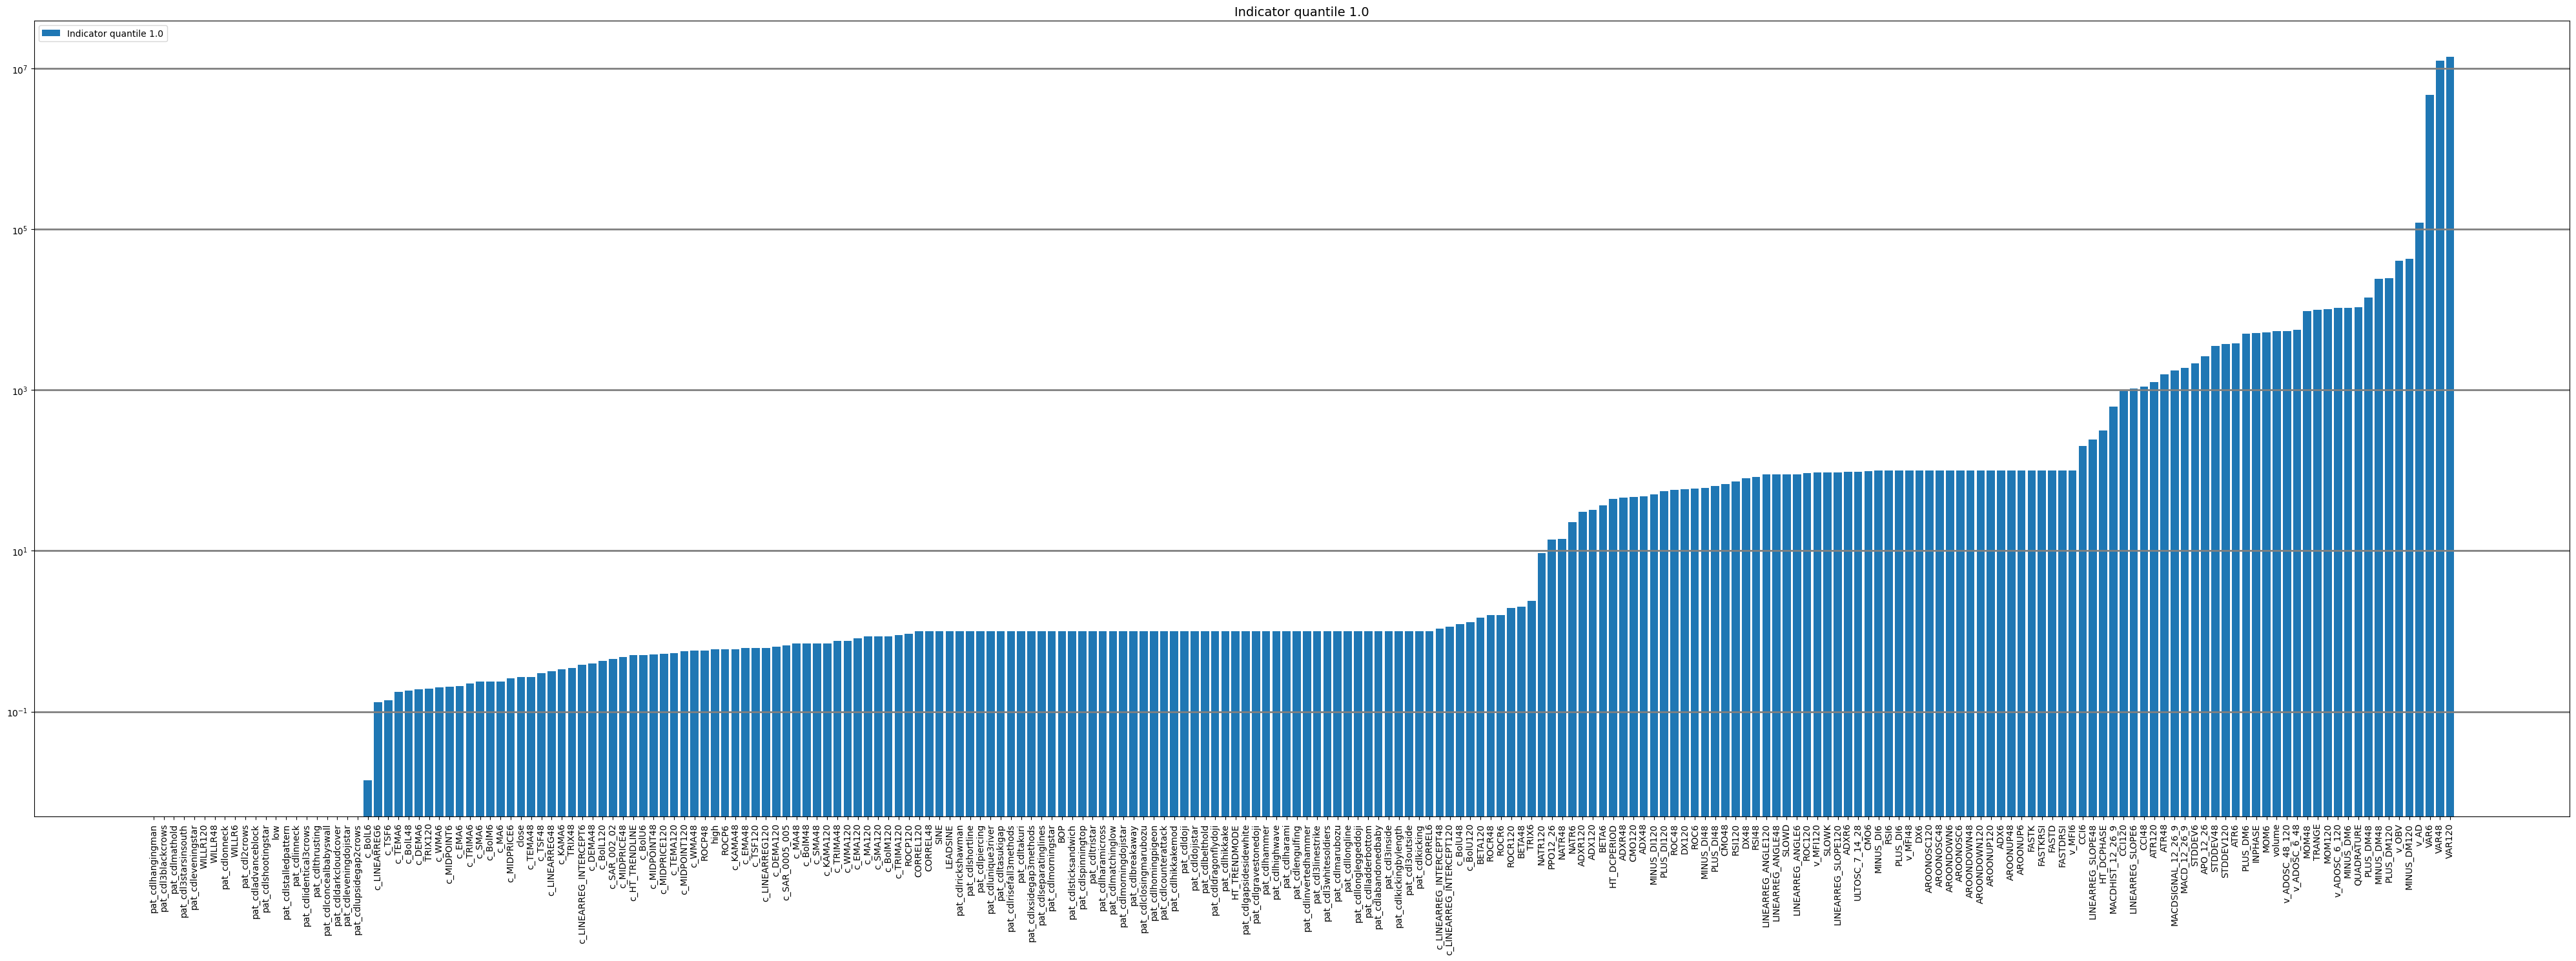

In [42]:
# Plot the max value of each indicator 
chart_name="Indicator quantile 1.0"
fig, ax1 = plt.subplots(figsize=(40,15))
ax1.set_title(chart_name, fontsize=14)

plt.xticks(rotation=90, ha='center')

sortedDS = quantilesDF.loc[1.0,:].sort_values()

# Plot the 'baseline'
ax1.bar(sortedDS.index, sortedDS.values, label="Indicator quantile 1.0")

ax1.set_yscale('log')
ax1.grid(color='gray', linestyle='-', linewidth=2, axis='y')

# Show a legend
plt.legend(loc="upper left")

plt.tight_layout()

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

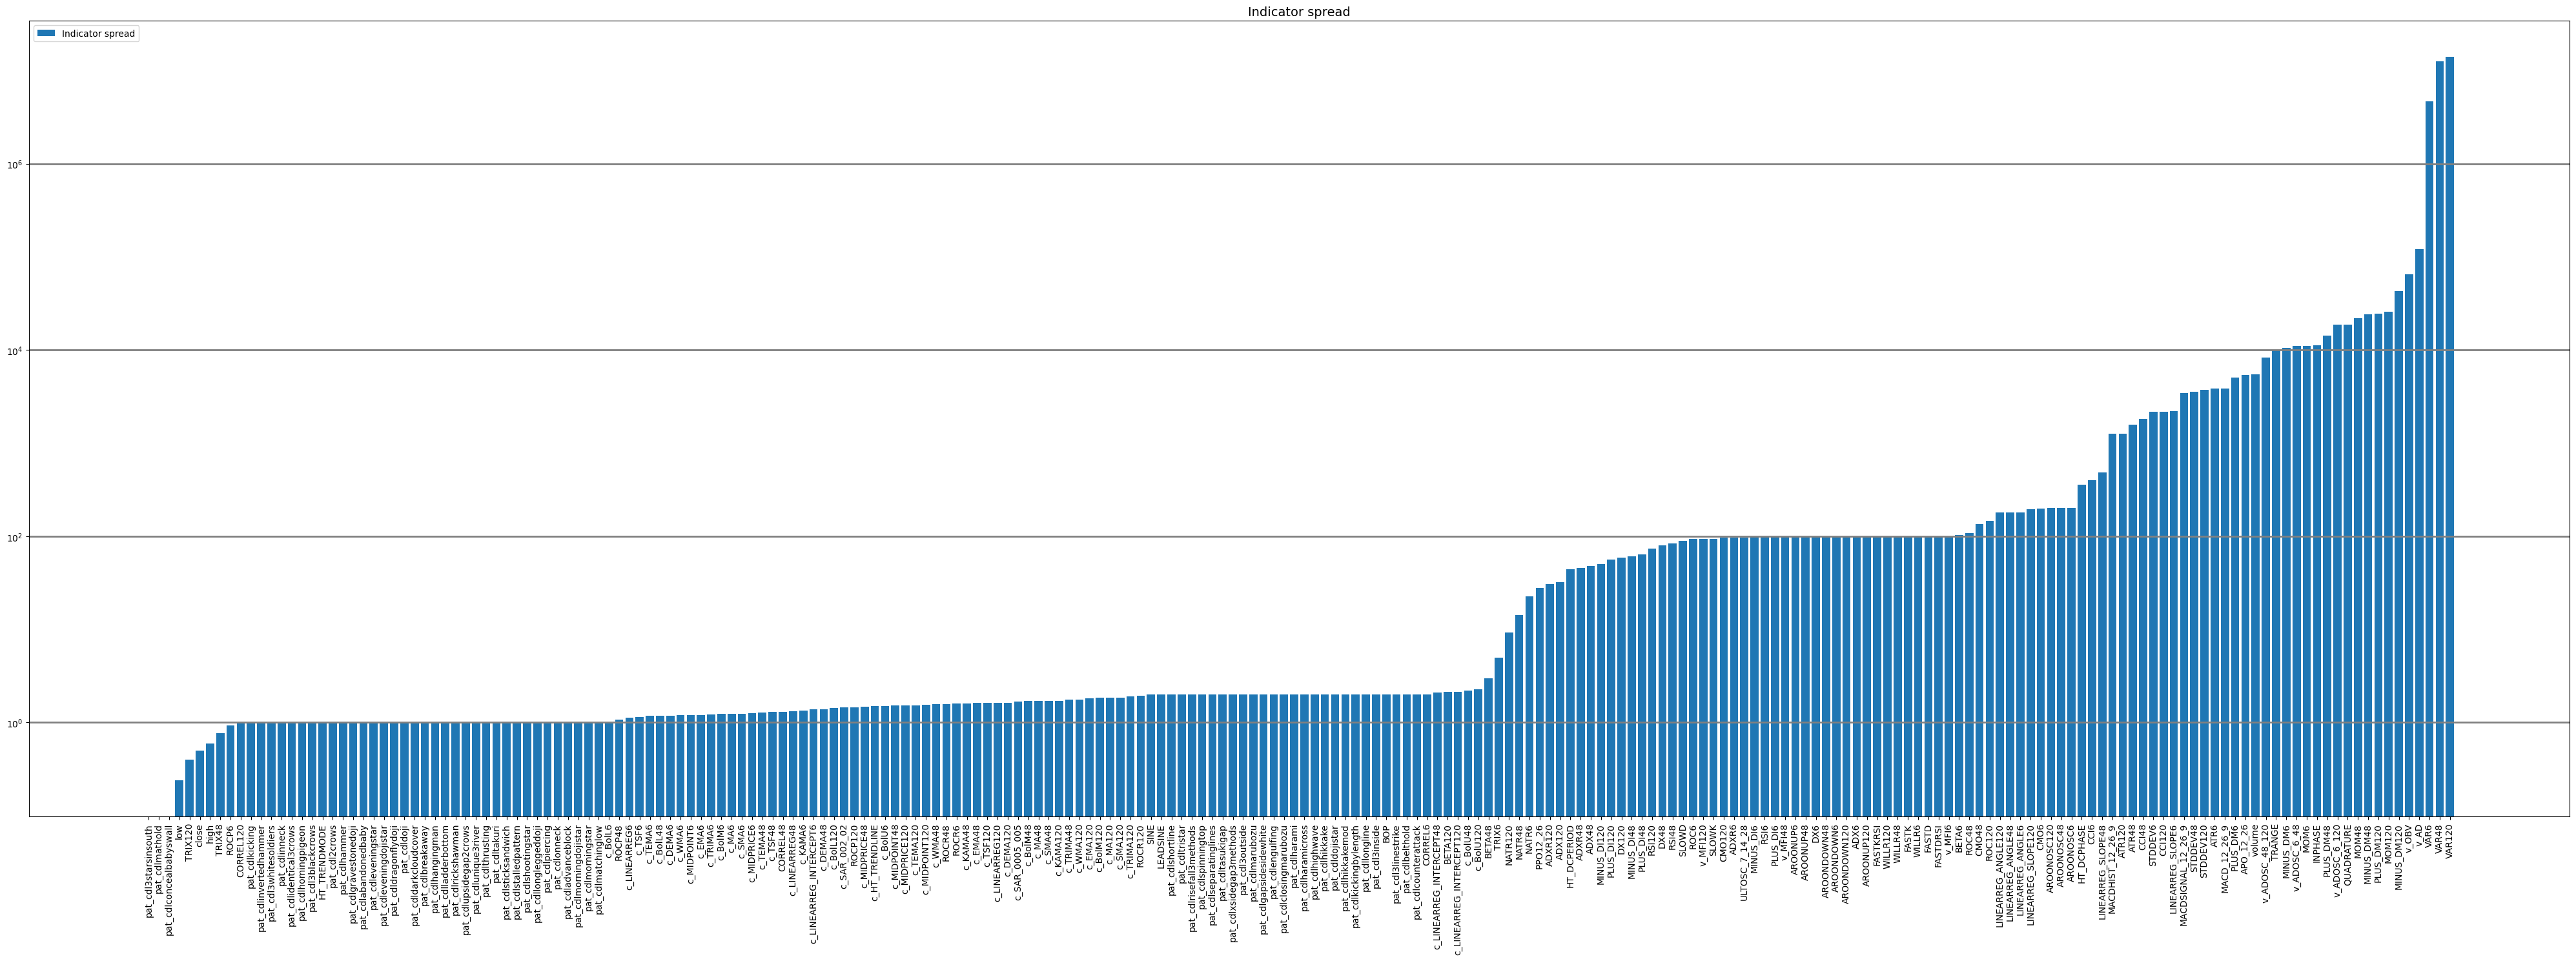

In [43]:
# Plot the spread value of each indicator 
chart_name="Indicator spread"
fig, ax1 = plt.subplots(figsize=(40,15))
ax1.set_title(chart_name, fontsize=14)

plt.xticks(rotation=90, ha='center')

sortedDS = (quantilesDF.loc[1.0,:] - quantilesDF.loc[0.0,:] ).sort_values()

# Plot the 'baseline'
ax1.bar(sortedDS.index, sortedDS.values, label="Indicator spread")

ax1.set_yscale('log')
ax1.grid(color='gray', linestyle='-', linewidth=2, axis='y')

# Show a legend
plt.legend(loc="upper left")

plt.tight_layout()

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Demonstration of XBlockGenerator

The `XBlockGenerator` class is used to generate time-frame slices (= X-blocks) out of a time series table of tick and indicator data.
For this task, an input `pd.DataFrame` `tickAndIndicatorDF` is processed row by row.
It is called 'X' because its purpose is to be used as input data for machine learning networks (== X-data).

Every X-block is created by using a specific amount of table rows, defined by the `int` parameter `X_Block_lenght`.
If the tick data is in hours and `X_lookback_cnt=12`, the generator would return slices of 12 hours.
The step size between the X-blocks is 1, so the resulting DFs in the example would be: 00:00-11:00, 01:00-12:00, 02:00-13:00, ...

For demonstration purposes, only a OHLCV dataframe without indicators is used, to keep the confusion low!

In [44]:
# Load the OHLCV table
tickdata = pd.read_csv(EXAMPLE_FILE_PATHS[0])
tickdata.set_index("startsAt", inplace = True) # Todo: Take care of the index name
tickdata.sort_index()

# Let the table start at an interesting position (just for demonstration)
tickdata = tickdata.iloc[10000:,]

tickdata

open          high           low         close     volume  \
startsAt                                                                        
1485928800    975.655125    975.655125    975.655125    975.655125   0.000000   
1485932400    973.400000    973.400000    973.400000    973.400000   0.003092   
1485936000    973.400000    973.400000    973.400000    973.400000   0.000000   
1485939600    973.400000    973.400000    973.400000    973.400000   0.000000   
1485943200    962.000000    973.735000    954.849711    973.735000   0.140184   
...                  ...           ...           ...           ...        ...   
1627761600  41312.243514  41819.689357  41174.024002  41504.090831   6.954679   
1627765200  41532.010689  41974.904927  41532.010689  41960.070000   7.271290   
1627768800  41961.294435  41977.030664  41645.385796  41870.548474   6.137356   
1627772400  41838.657138  41942.798100  41324.944231  41448.430802  10.411857   
1627776000  41460.515600  41779.055816  41148.417800  41697.318684  18.597236   

              quoteVolume  
startsAt                   
1485928800       0.000000  
1485932400       3.009714  
1485936000       0.000000  
1485939600       0.000000  
1485943200     134.740802  
...                   ...  
1627761600  288855.157694  
1627765200  303437.038256  
1627768800  256691.373423  
1627772400  434411.360678  
1627776000  772063.318313  

[39403 rows x 6 columns]

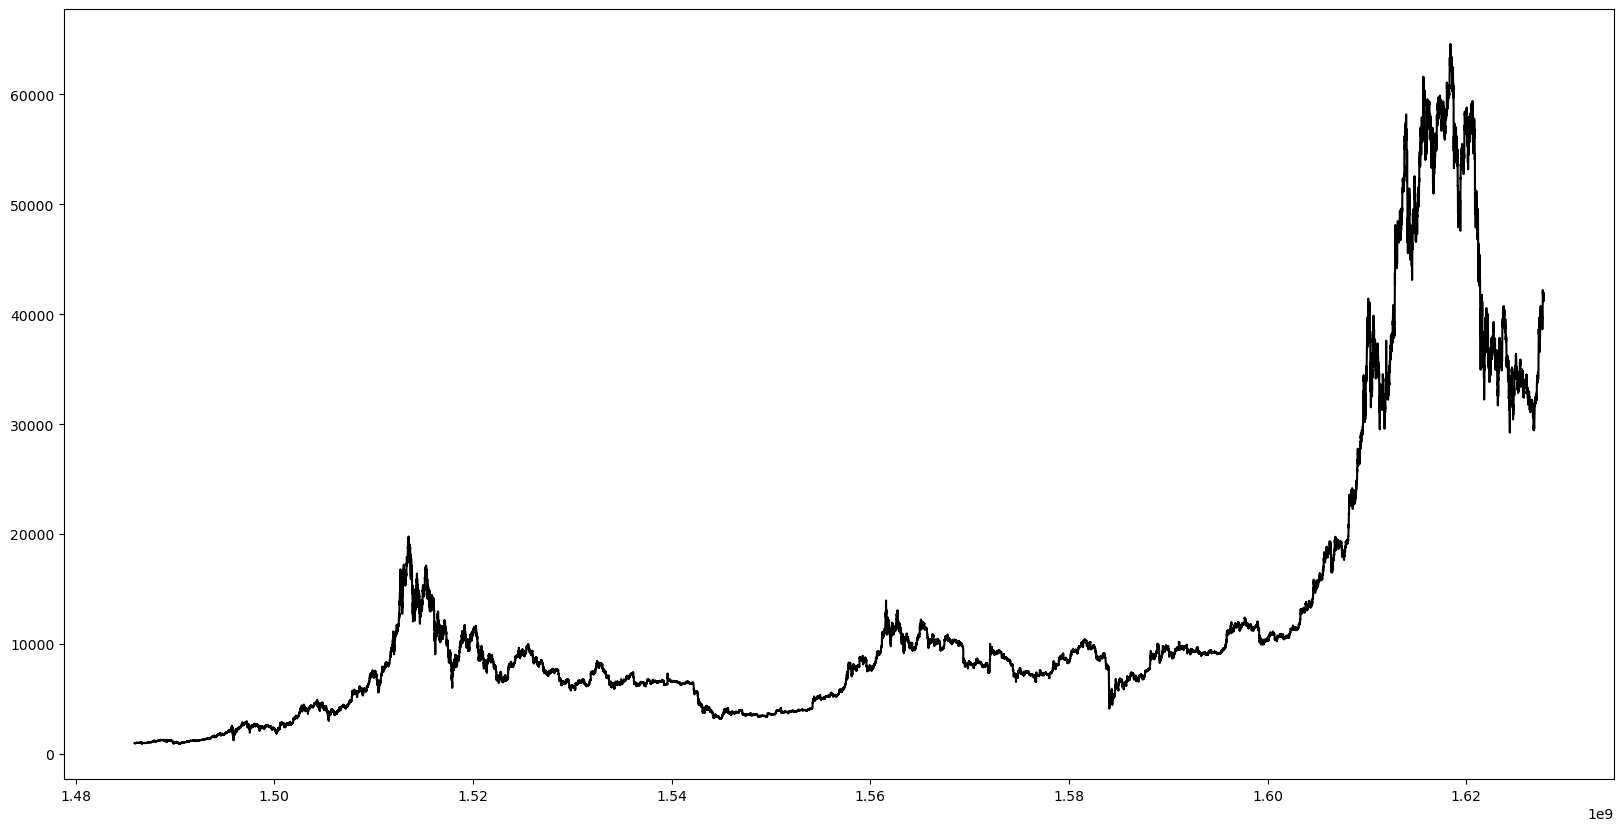

In [45]:
# Plot the open column of the data set
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot(tickdata.loc[:,'open'], color="black")

In [46]:
# Generate 20 X-Blocks with a size of 48 timesteps
# The generated X-blocks do not have column names any more, as they are just an array

xBlockGenerator = DataStreamCreator.XBlockGenerator(tick_and_indicator_DF=tickdata,
                                                    generator_batch_size=20,
                                                    X_Block_lenght=48
                                                    )
xBlocks = next(xBlockGenerator)
print(f"tickdata.shape: {tickdata.shape}")
print(f"xBlocks.shape: {xBlocks.shape}")

tickdata.shape: (39403, 6)
xBlocks.shape: (20, 48, 6)


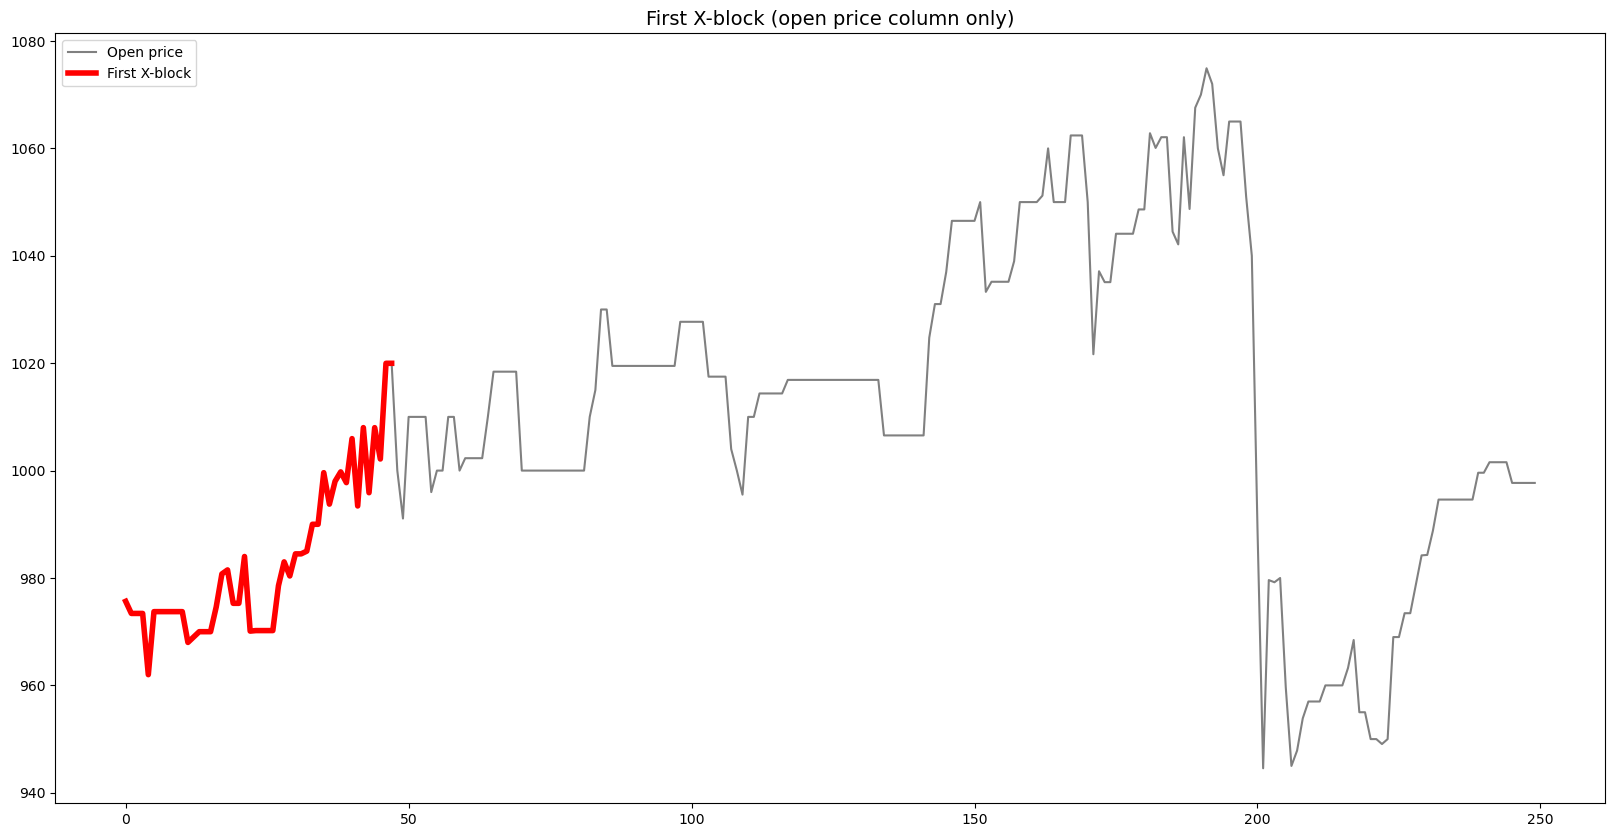

In [47]:
# Plot the first X-Block
chart_name="First X-block (open price column only)"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

x_len = 250

# Plot the 'baseline'
ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

# Plot the first block
ax1.plot(xBlocks[0,:,0], color="red", linewidth = 4, label="First X-block")

# Show a legend
plt.legend(loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

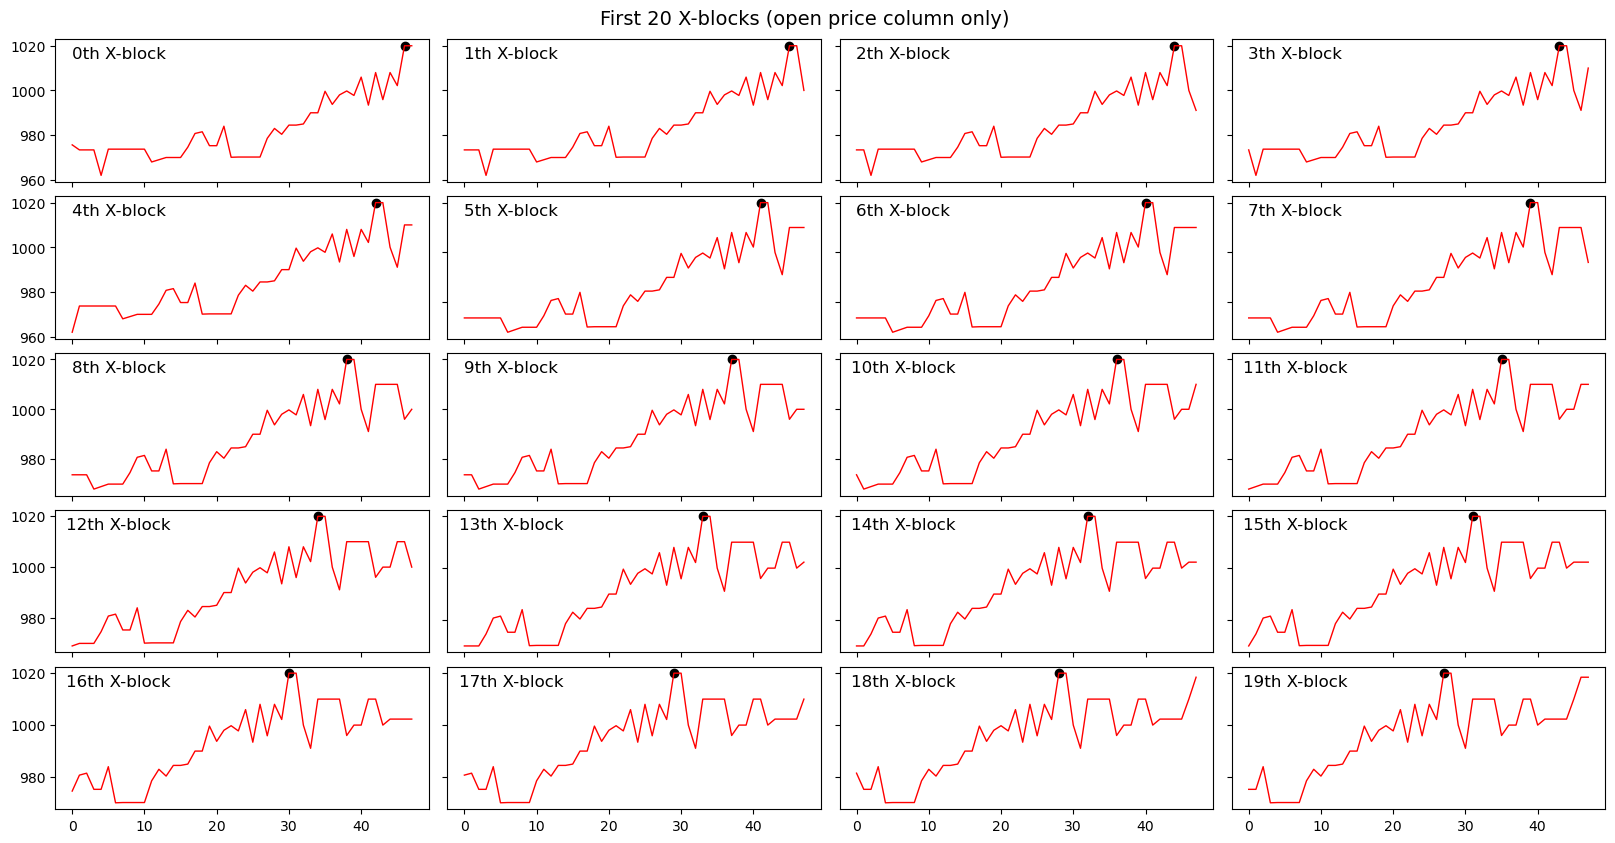

In [48]:
# Plot the first 20 X-blocks
nHorzontal = 5
nVertical = 4
i = 0

chart_name="First 20 X-blocks (open price column only)"
fig, axs = plt.subplots(nHorzontal, nVertical,figsize=(20,10))
fig.subplots_adjust(wspace=0.05, hspace=0.1)

fig.suptitle(chart_name, fontsize=14, y=0.91)

markerX = xBlocks[0,:,0][-2]

for nH in range(nHorzontal):
    for nV in range(nVertical):
        # Set the title
        axs[nH, nV].set_title(f"{i}th X-block", x=0.17, y=1.0, pad=-14)
        
        # Plot the i-th block
        axs[nH, nV].plot(xBlocks[i,:,0], color="red", linewidth = 1, label=f"{i}th X-block")
        
        # Plot a marker to visualize the movement
        axs[nH, nV].scatter(x=[xBlocks.shape[1]-2-i], y=[markerX], color="black")
                
        i+=1

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [49]:
# Generate X-Blocks until there is no more data to get the block
# at the end of the dataset

latest_blocks = None

while True:
  try:
    latest_blocks = next(xBlockGenerator)
  except StopIteration:
    # Exit if there is no more data
    break
latest_blocks.shape

(15, 48, 6)

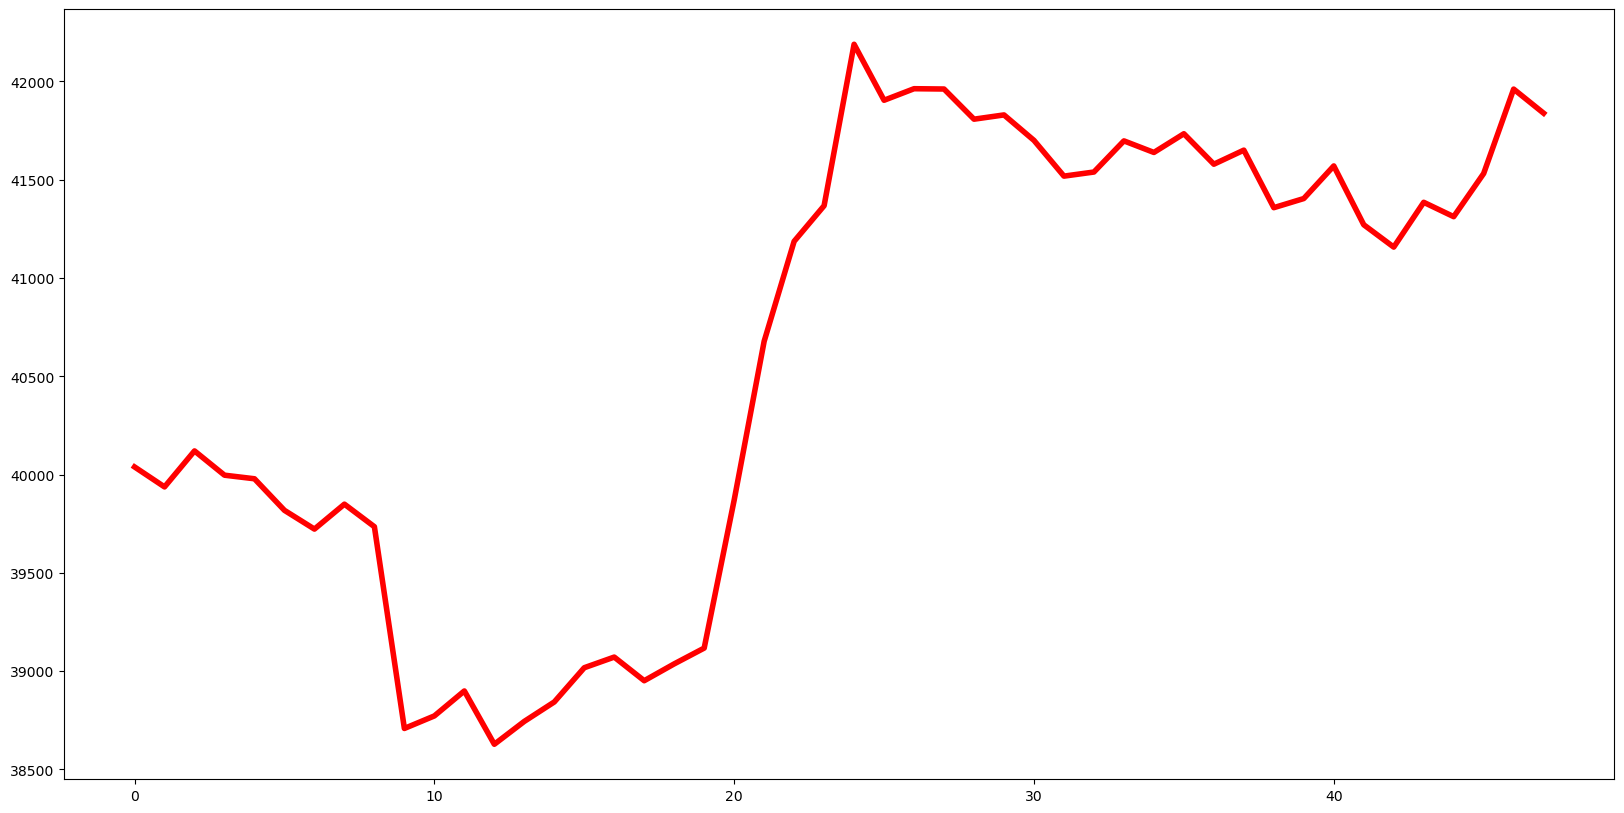

In [50]:
# Plot the latest data
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(latest_blocks[-1,:,0], color="red", linewidth = 4)

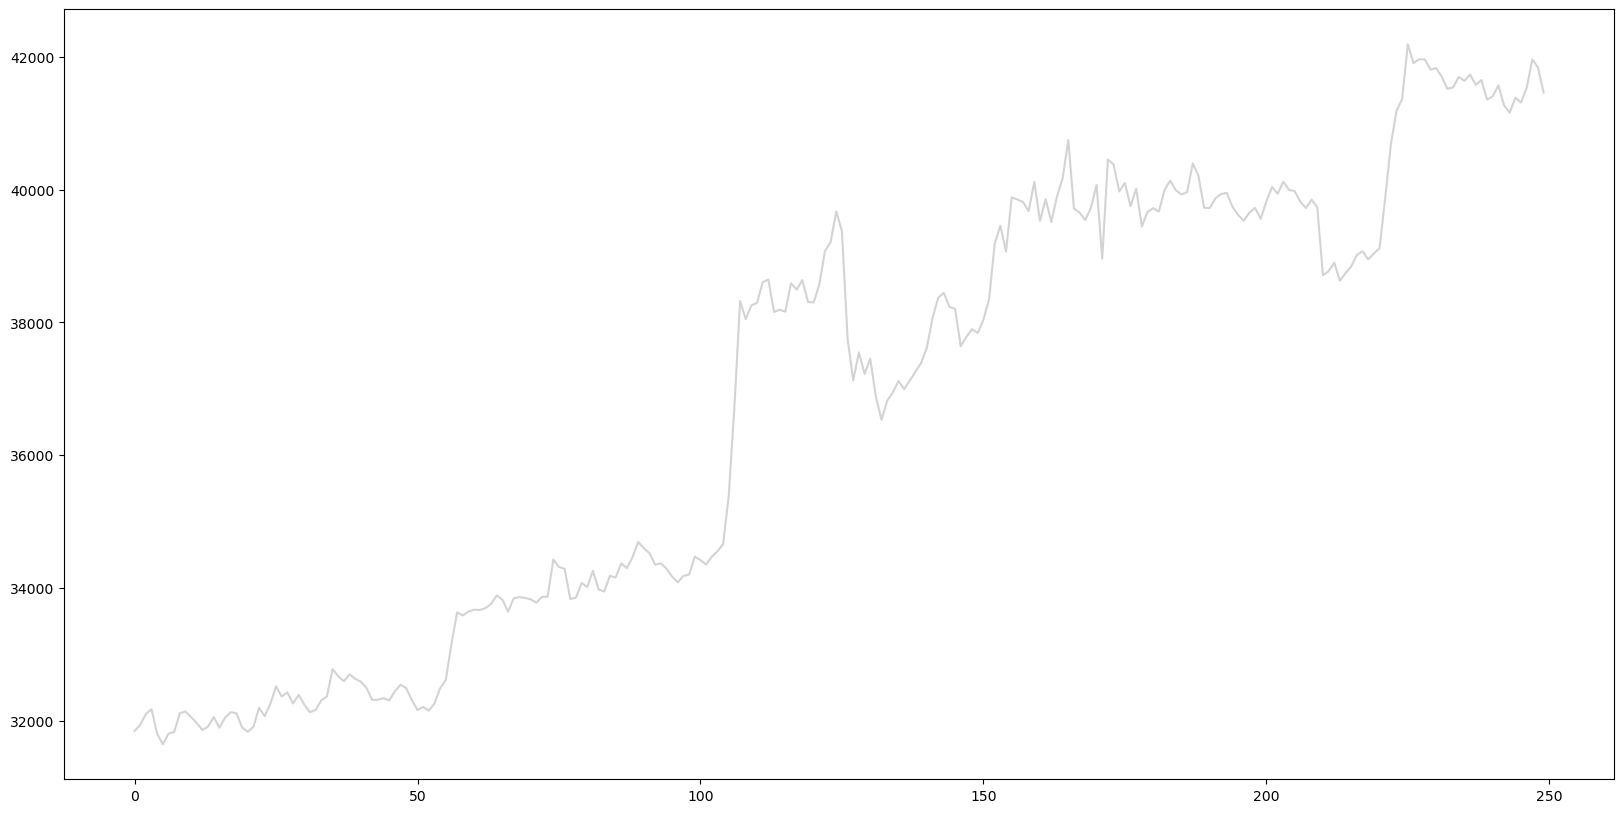

In [51]:
# Plot the end of the data table
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot(tickdata.loc[:,'open'].values[-250:], color="lightgray")

# Demonstration of YDataGenerator

The `YDataGenerator` class is used to generate future information for training out of a time series table of tick and indicator data.
This can for example be the assets relative price or gain in 24 hours, the direction of movement, or trade entry and exit signals.

IMPORTANT: This class can of course not look into the future, so if you want to output the price in 24 hours, this can only be done until
table index `len(timestamp rows) - 24`, otherwise it would really have to look into the future!

The purpose of this class is to generate machine-learning target data (y-values) according to the X-Blocks generated by the `XBlockGenerator`.
The X-Block contains data from the past, which is known in a live application, while the Y data is unknown in the live application, and therefore has to be predicted.
Here, it can be generated for training purposes using historical data.

As a price basis for calculating the y data, the `open` column of the input table `tick_DF` is used.

There are 4 different types of y data available, which are shown each on its own in the following section.

# Todo: More fancy doku

The y data generator can be structure into 4 sections, namely the 4 different types of signals that can be generated.

---
### Y_DATA_TYPE_DIRECTION_FLOAT

This data type generates a direction signal of price movement and its derivation. It takes the following parameters:
- `direction_ma_timespan`: Default 200, this parameter describes how fast the direction information follows price changes
- `derivation_ma_timespan`: Default 100, this parameter describes how fast the derivation information direction changes
- `direction_derivation_shift_span`: Default 0, this parameter sets a shifting of the direction and derivation information

The output of this data type is the direction of price movement and its derivation: `np.array [direction, directionDerivation]`

---
### Y_DATA_TYPE_DIRECTION_CATEGORICAL

This data type generates a direction signal of price movement and its derivation. It takes the following parameters:
- `direction_ma_timespan`: Default 200, this parameter describes how fast the direction information follows price changes
- `derivation_ma_timespan`: Default 100, this parameter describes how fast the derivation information direction changes
- `direction_derivation_shift_span`: Default 0, this parameter sets a shifting of the direction and derivation information
- `fall_threshold`: Default -0.2, this parameter set a limit for the direction value from which it shall be considered rising. The derivation of the direction has also to be over 0 to assume rising.
- `rise_threshold`: Default 0.1, this parameter set a limit for the direction value from which it shall be considered falling

The output of this data type is the integer category of the price movement based on its direction info (from the previous Y_DATA_TYPE_DIRECTION_FLOAT): `np.array [integerCategory]`

---
### Y_DATA_TYPE_TRADE_SIGNALS

This is the most sophisticated data generator based on the direction of price movement and its derivation. It uses three entry and two exit thresholds to generate trade signals whether one should enter (-> buy) or exit (-> sell). As the future is known in the train data generation step, very precise entry and exit signals can be generated. These signals can then be trained into a machine learning network.

As these parameters are rather sensitve and depend on the type of tick data (crypto, stock, long/short-term, ...), there will be a notebook for finding an optimum of them based on a training data set. (*Todo: Add the finder notebook*)

It takes the following parameters:
- `direction_ma_timespan`: Default 200, this parameter describes how fast the direction information follows price changes
- `derivation_ma_timespan`: Default 100, this parameter describes how fast the derivation information direction changes
- `direction_derivation_shift_span`: Default 0, this parameter sets a shifting of the direction and derivation information
- `future_direction_shift_timespan`: Default 24, this parameter determines from which future timestep the information is used to generate signals. (-> Look if a trade would be profitable)
- `entr_thr1`, `entr_thr2`, `entr_thr3`: Thresholds for generating entry signals based on this equation: `(direction >= entr_thr1) & (_direction_futureshifted >= entr_thr2) & (directionDerivation >= entr_thr3)`
- `exit_thr1`, `exit_thr2`: Thresholds for generating exit signals based on this equation: `(direction <= exit_thr1) & (_direction_futureshifted <= exit_thr2)`

The output of this data type is the one-hot-encoded category of the price movement: `np.array [entry, exit, neutral]`

---

In [52]:
# Load the OHLCV table
tickdata = pd.read_csv(EXAMPLE_FILE_PATHS[0])
tickdata.set_index("startsAt", inplace = True) # Todo: Take care of the index name
tickdata.sort_index()
 
tickdata

open          high           low         close     volume  \
startsAt                                                                        
1449928800    420.000000    420.000000    420.000000    420.000000   0.000304   
1449932400    420.000000    420.000000    420.000000    420.000000   0.000000   
1449936000    420.000000    420.000000    420.000000    420.000000   0.000000   
1449939600    420.000000    420.000000    420.000000    420.000000   0.000000   
1449943200    420.000000    420.000000    420.000000    420.000000   0.000000   
...                  ...           ...           ...           ...        ...   
1627761600  41312.243514  41819.689357  41174.024002  41504.090831   6.954679   
1627765200  41532.010689  41974.904927  41532.010689  41960.070000   7.271290   
1627768800  41961.294435  41977.030664  41645.385796  41870.548474   6.137356   
1627772400  41838.657138  41942.798100  41324.944231  41448.430802  10.411857   
1627776000  41460.515600  41779.055816  41148.417800  41697.318684  18.597236   

              quoteVolume  
startsAt                   
1449928800       0.127596  
1449932400       0.000000  
1449936000       0.000000  
1449939600       0.000000  
1449943200       0.000000  
...                   ...  
1627761600  288855.157694  
1627765200  303437.038256  
1627768800  256691.373423  
1627772400  434411.360678  
1627776000  772063.318313  

[49403 rows x 6 columns]

---
### Visualization of y for Y_DATA_TYPE_DIRECTION_FLOAT

In [53]:
# Get the template parameter dict for this y type
Y_PARAM_DICT_TEMPLATE = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_FLOAT)
Y_PARAM_DICT_TEMPLATE

{'dataType': 0,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0}

In [54]:
yDataGenerator = DataStreamCreator.YDataGenerator(tick_DF=tickdata,
                                                    generator_batch_size=10000,
                                                    first_batch_slice_start_index=0,
                                                    y_type_dict=Y_PARAM_DICT_TEMPLATE
                                                    )
yData = next(yDataGenerator)
print(f"yData.shape: {yData.shape}")

yData.shape: (10000, 2)


In [55]:
yData[:5]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [56]:
y_dir = yData[:,0]
y_dir_derivation = yData[:,1]

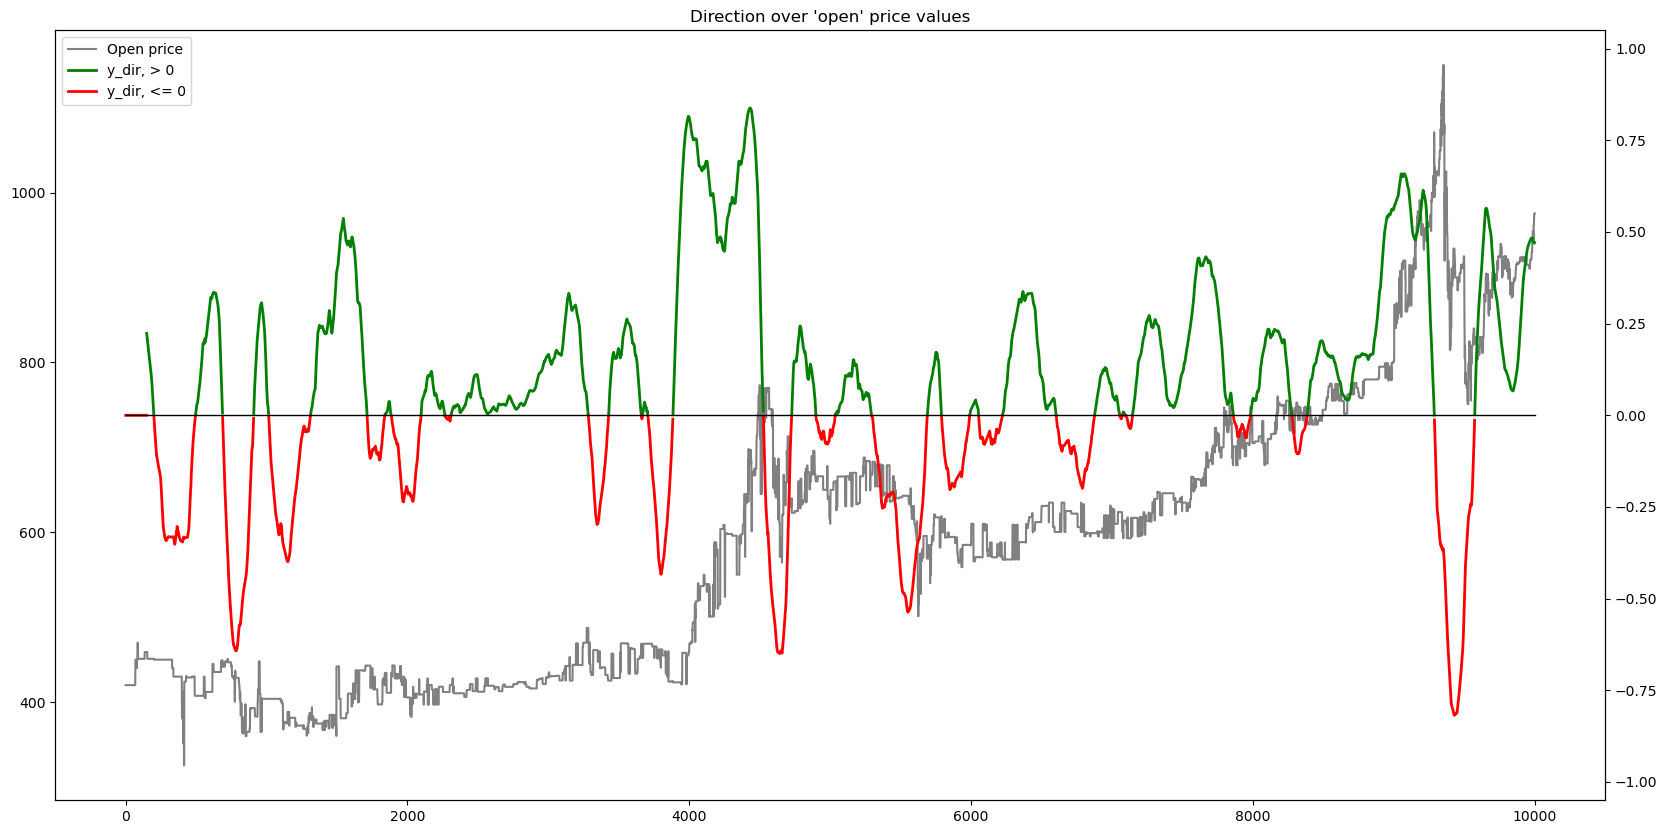

In [57]:
# Plot the direction information
chart_name="Direction over 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-1.05,1.05)

# Split the direction data into rise and fall for plotting
y_dir_rise = np.array(y_dir)
y_dir_fall = np.array(y_dir)

y_dir_rise[y_dir_rise <= 0] = np.nan
y_dir_fall[y_dir_fall > 0] = np.nan

ax2.plot(y_dir_rise, color="green", linewidth=2, label="y_dir, > 0")
ax2.plot(y_dir_fall, color="red", linewidth=2, label="y_dir, <= 0")


# Plot a zero line
ax2.plot([0,x_len], [0,0], color="black", linewidth=1)

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

---
### Now lets try to shift the direction and derivation info for 7 days (= 168 hours)

This can be used to get y data from more far into the future

In [58]:
# Get the template parameter dict for this y type
Y_PARAM_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_FLOAT)
Y_PARAM_DICT['direction_derivation_shift_span'] = 7*24
Y_PARAM_DICT

{'dataType': 0,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 168}

In [59]:
yDataGeneratorShifted = DataStreamCreator.YDataGenerator(tick_DF=tickdata,
                                                    generator_batch_size=10000,
                                                    first_batch_slice_start_index=0,
                                                    y_type_dict=Y_PARAM_DICT
                                                    )
yDataShifted = next(yDataGeneratorShifted)
print(f"yDataShifted.shape: {yDataShifted.shape}")

yDataShifted.shape: (10000, 2)


In [60]:
y_dir_shifted = yDataShifted[:,0]
y_dir_derivation_shifted = yDataShifted[:,1]

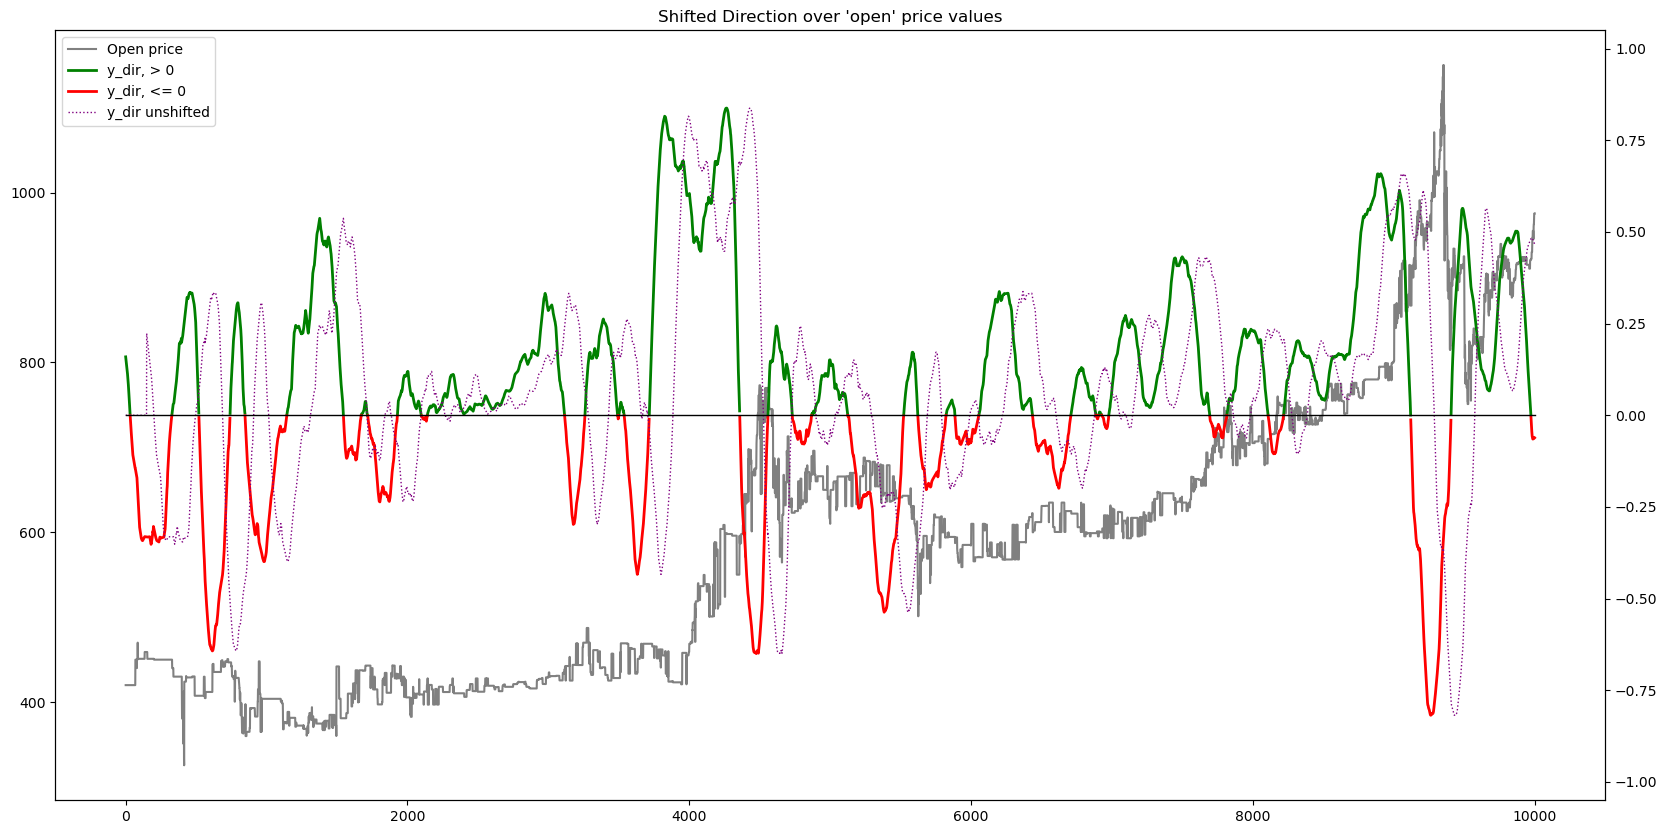

In [61]:
# Plot the shifted direction information
chart_name="Shifted Direction over 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-1.05,1.05)

# Split the direction data into rise and fall for plotting
y_dir_rise = np.array(y_dir_shifted)
y_dir_fall = np.array(y_dir_shifted)

y_dir_rise[y_dir_rise <= 0] = np.nan
y_dir_fall[y_dir_fall > 0] = np.nan

ax2.plot(y_dir_rise, color="green", linewidth=2, label="y_dir, > 0")
ax2.plot(y_dir_fall, color="red", linewidth=2, label="y_dir, <= 0")

ax2.plot(y_dir, color="purple", linewidth=1, linestyle=":", label="y_dir unshifted")

# Plot a zero line
ax2.plot([0,x_len], [0,0], color="black", linewidth=1)

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

---
### Visualization of y for Y_DATA_TYPE_DIRECTION_CATEGORICAL

In [62]:
# Get the template parameter dict for this y type
Y_PARAM_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_CATEGORICAL)
Y_PARAM_DICT

{'dataType': 1,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0,
 'fall_threshold': -0.2,
 'rise_threshold': 0.1}

In [63]:
yDataGenerator = DataStreamCreator.YDataGenerator(tick_DF=tickdata,
                                                    generator_batch_size=10000,
                                                    first_batch_slice_start_index=0,
                                                    y_type_dict=Y_PARAM_DICT
                                                    )
yCategory = next(yDataGenerator)
print(f"yCategory.shape: {yCategory.shape}")

yCategory.shape: (10000,)


In [64]:
yCategory[:400]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

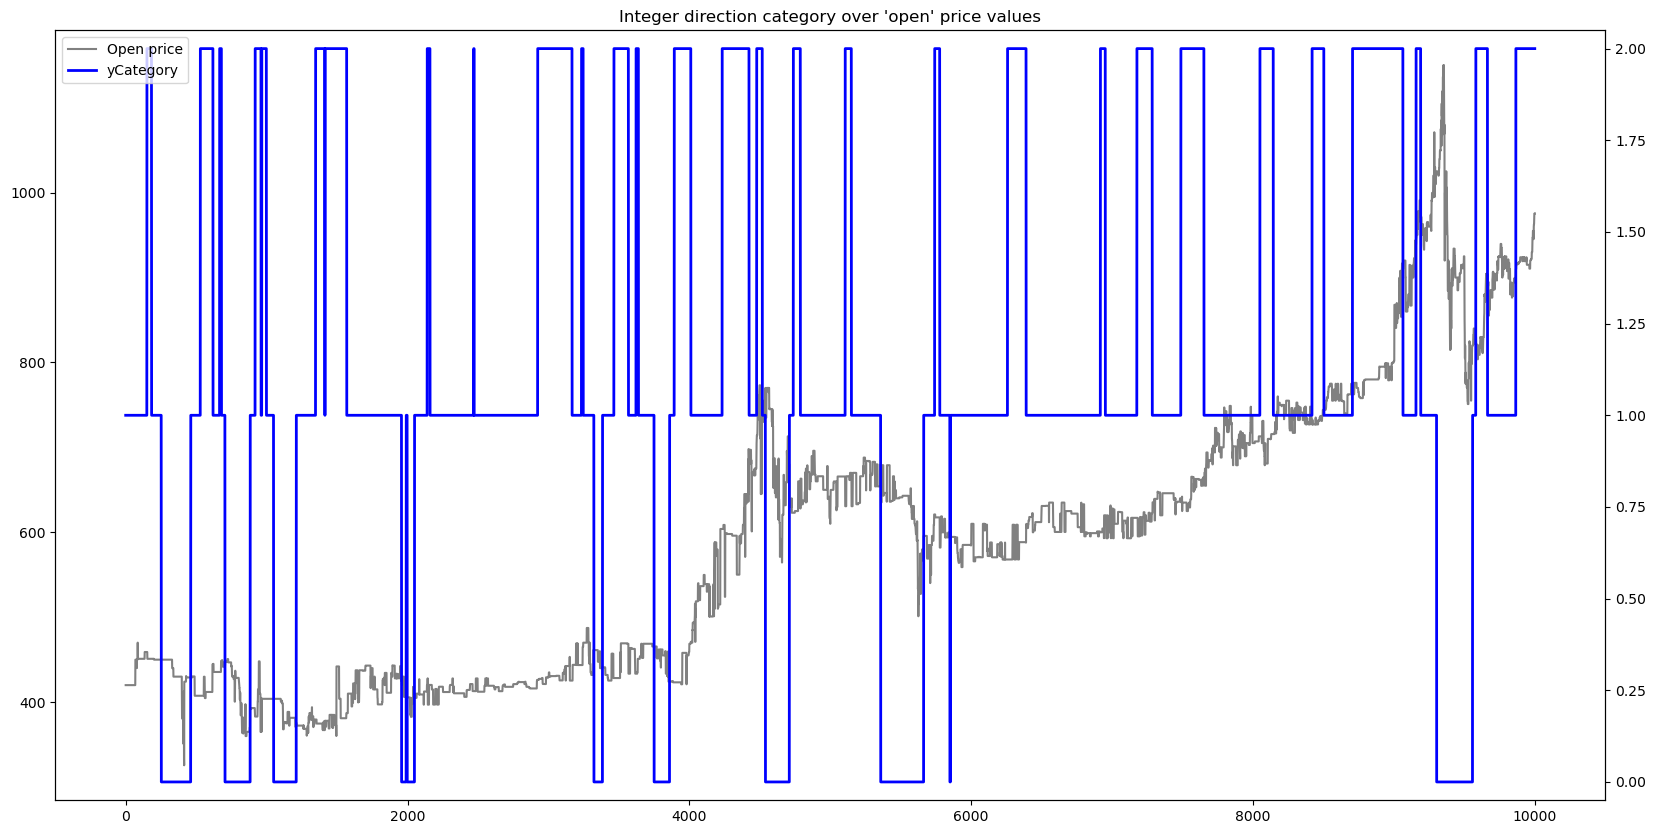

In [65]:
# Plot the integer category information
chart_name="Integer direction category over 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-0.05,2.05)

ax2.plot(yCategory, color="blue", linewidth=2, label="yCategory")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

In [66]:
# Split it into seperate category arrays
yCategoryFall = np.zeros(yCategory.shape)
yCategoryNeutral = np.zeros(yCategory.shape)
yCategoryRise = np.zeros(yCategory.shape)

yCategoryFall[0 == yCategory] = 1
yCategoryNeutral[1 == yCategory] = 1
yCategoryRise[2 == yCategory] = 1

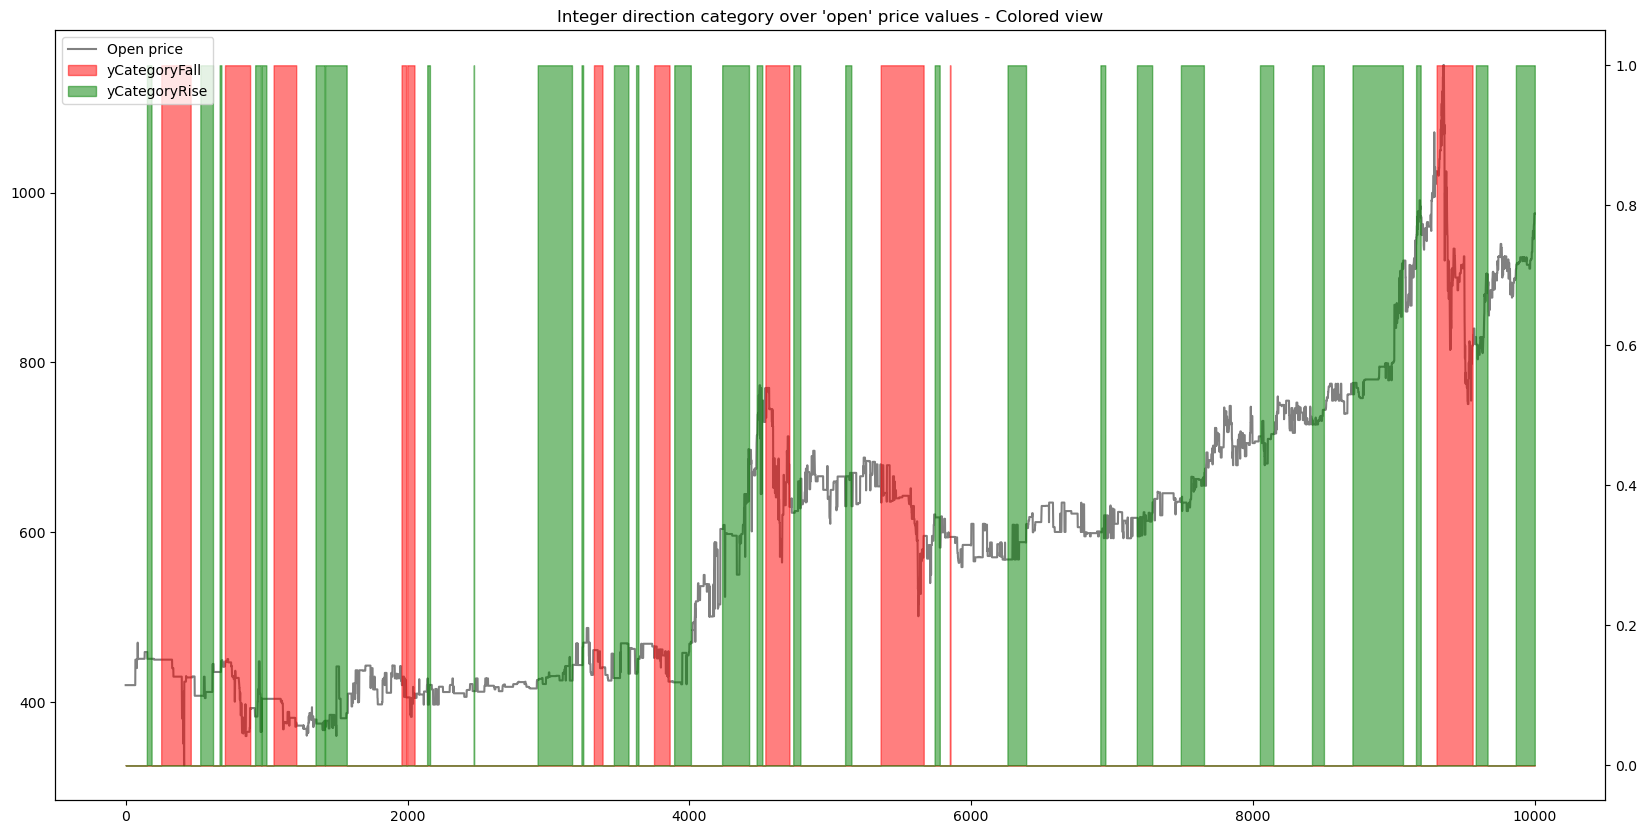

In [67]:
# Plot a nicer category information
chart_name="Integer direction category over 'open' price values - Colored view"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-0.05,1.05)

# ax2.plot(yCategoryFall, color="red", linewidth=2, label="yCategoryFall")
# ax2.plot(yCategoryNeutral, color="blue", linewidth=1, label="yCategoryNeutral")
# ax2.plot(yCategoryRise, color="green", linewidth=2, label="yCategoryRise")

ax2.fill_between(range(x_len), yCategoryFall , alpha=0.5, color="red", label="yCategoryFall")
ax2.fill_between(range(x_len), yCategoryRise , alpha=0.5, color="green", label="yCategoryRise")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

---
### Visualization of y for Y_DATA_TYPE_TRADE_SIGNALS

In [68]:
# Get the template parameter dict for this y type
Y_PARAM_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_TRADE_SIGNALS)

# Entry and exit threshold have to be adapted to the type of tick data (crypto, stock, long/short-term, ...)
Y_PARAM_DICT['entr_thr1'] = 0.5
Y_PARAM_DICT['entr_thr2'] = 0.4

Y_PARAM_DICT

{'dataType': 2,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0,
 'future_direction_shift_timespan': 24,
 'entr_thr1': 0.5,
 'entr_thr2': 0.4,
 'entr_thr3': 0.0,
 'exit_thr1': -0.5,
 'exit_thr2': 0.1}

In [69]:
yDataGenerator = DataStreamCreator.YDataGenerator(tick_DF=tickdata,
                                                    generator_batch_size=10000,
                                                    first_batch_slice_start_index=0,
                                                    y_type_dict=Y_PARAM_DICT
                                                    )
ySignals = next(yDataGenerator)
print(f"ySignals.shape: {ySignals.shape}")

ySignals.shape: (10000, 3)


In [70]:
ySignals[:5]

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [71]:
entrySignals = ySignals[:,0]
exitSignals = ySignals[:,1]
neutralSignals = ySignals[:,2]

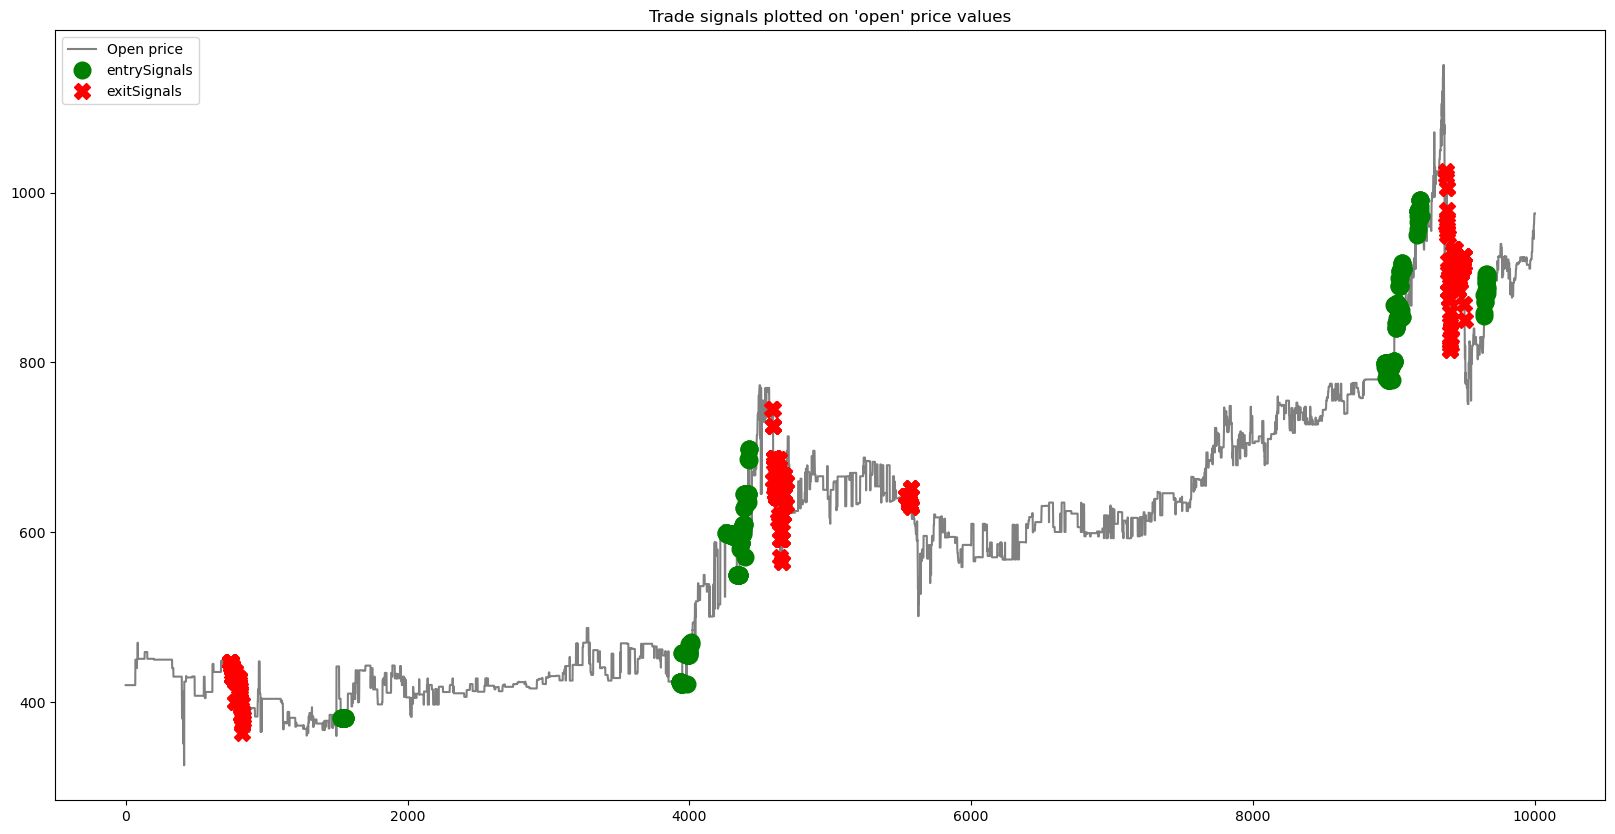

In [72]:
# Plot the entry and exit signals
chart_name="Trade signals plotted on 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

# Multiply the signals with the price to draw them directly on the price graph
openPriceValues = tickdata.loc[:,'open'].values[:x_len]
entrySignalsChart = entrySignals * openPriceValues
exitSignalsChart = exitSignals * openPriceValues

entrySignalsChart[0 == entrySignalsChart] = np.nan
exitSignalsChart[0 == exitSignalsChart] = np.nan

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax1.plot(entrySignalsChart, color="green", linewidth=0, marker="o", markersize="12", label="entrySignals")
ax1.plot(exitSignalsChart, color="red", linewidth=0, marker="X", markersize="12", label="exitSignals")

# Show a legend
ax1.legend(loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Demonstration of FileListToDataStream

This method creates a stream of `X-Block` and `y-data` arrays out of a list of csv file names. For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator`.

Important in this example is, that the last timestamp of an X-Block (a frame from the past) matches the timestamp of the y-data entry (lookout into the future of the price).

In the example the first X/y pair at timestep `T` is picked:

    Shape of X-Block array: (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES) -> (32, 128, 226) --> Pick first element at [0,:,:] --> xT=(128, 226), or (128 Timestep, 226 Features)
    Shape of y-data array: (BATCH_SIZE, DIRECTION & DERVIATION) -> (32, 2) --> Pick first element at [0,:] --> yT=(2), or (Price Direction and Direction Derivation)


In [73]:
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_FLOAT)
Y_TYPE_DICT

{'dataType': 0,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0}

In [74]:
# Initialize the FileListToDataStream generator
dataStream = DataStreamCreator.FileListToDataStream(fileList = EXAMPLE_FILE_PATHS,
                                                     batch_size = BATCH_SIZE,
                                                     X_Block_lenght = X_BLOCK_LENGHT,
                                                     y_type_dict=Y_TYPE_DICT
                                                    )
dataStream

INFO:root:File 'BTC-USDT.csv' loaded, 1 left
INFO:root:File 'ETH-USDT.csv' loaded, 0 left


In [75]:
# Get the first batch
batch = next(dataStream)
print(f"Shape of X-Block array: (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES) -> {batch['X'].shape}")
print(f"Shape of y-data array: (BATCH_SIZE, DIRECTION & DERVIATION) -> {batch['y'].shape}")

Shape of X-Block array: (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES) -> (32, 128, 226)
Shape of y-data array: (BATCH_SIZE, DIRECTION & DERVIATION) -> (32, 2)


In [76]:
list.reverse([1,2,3,4])

In [77]:
batch['X']

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -9.87114581e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -9.87114581e-04],
        ...,
        [ 0.00000000e+00,  2.63745789e+01,  2.60736014e+01, ...,
          0.00000000e+00,  1.15766820e+03, -9.87114581e-04],
        [ 0.00000000e+00,  2.61842447e+01,  2.60684701e+01, ...,
          0.00000000e+00,  1.15766820e+03, -9.87114581e-04],
        [ 0.00000000e+00,  2.59978758e+01,  2.60641940e+01, ...,
          0.00000000e+00,  1.15766820e+03, -9.87114581e-04]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [78]:
batch['y']

array([[ 0.        , -0.00585171],
       [ 0.        , -0.0061281 ],
       [ 0.        , -0.00650283],
       [ 0.        , -0.00689207],
       [ 0.        , -0.00729698],
       [ 0.        , -0.00771889],
       [ 0.        , -0.00815928],
       [ 0.        , -0.00870908],
       [ 0.        , -0.00929079],
       [ 0.        , -0.00990835],
       [ 0.        , -0.01056647],
       [ 0.        , -0.01141392],
       [ 0.        , -0.01233983],
       [ 0.        , -0.01336019],
       [ 0.        , -0.01449647],
       [ 0.        , -0.01577838],
       [ 0.        ,  0.00061225],
       [ 0.        ,  0.00056431],
       [ 0.        ,  0.00054141],
       [ 0.        ,  0.0005674 ],
       [ 0.        ,  0.00059319],
       [ 0.        ,  0.00061879],
       [ 0.        ,  0.00064693],
       [ 0.        ,  0.00066398],
       [ 0.        ,  0.00076479],
       [ 0.        ,  0.00078394],
       [ 0.        ,  0.00080295],
       [ 0.        ,  0.00079403],
       [ 0.        ,

In [79]:
# Fully consume the generator for testing
n = 0
logger.setLevel(logging.DEBUG) # To show where it exits

while True:
    try:
        batchLatest = next(dataStream)
        n+=1
        
        if(n % 100 == 0):
            logging.debug(n)
    except StopIteration:
        logging.debug("\n")
        logging.debug(n)
        
        logger.setLevel(logging.INFO)
        break

DEBUG:root:100
DEBUG:root:200
DEBUG:root:300
DEBUG:root:400
DEBUG:root:500
DEBUG:root:600
DEBUG:root:700
DEBUG:root:800
DEBUG:root:900
DEBUG:root:1000
DEBUG:root:1100
DEBUG:root:1200
DEBUG:root:1300
DEBUG:root:1400
DEBUG:root:1500
DEBUG:root:1600
DEBUG:root:1700
DEBUG:root:1800
DEBUG:root:1900
DEBUG:root:2000
DEBUG:root:2100
DEBUG:root:2200
DEBUG:root:2300
DEBUG:root:FileListToDataStream StopIteration - File list is empty (second check)
DEBUG:root:

DEBUG:root:2334


---
## Visualize the first X-Block

In [80]:
X = batchLatest['X']
X.shape

(32, 128, 226)

In [81]:
XT = X[0,:,:]
XT.shape

(128, 226)

### Plot the first block

The x-axis is the time dimension, the y-axis the value of the feature. Each feature has its own line.
It is easily recognizable that plotting of the features is difficult, due to a big value range and overlapping of features.

In the second chart there is a zoomed view, but due to the high feature count, it does not make it much more visible. But it nut necessary after all, as visualization is not the main purpose of the data.

**Todo:** Create a trained normalization for each feature

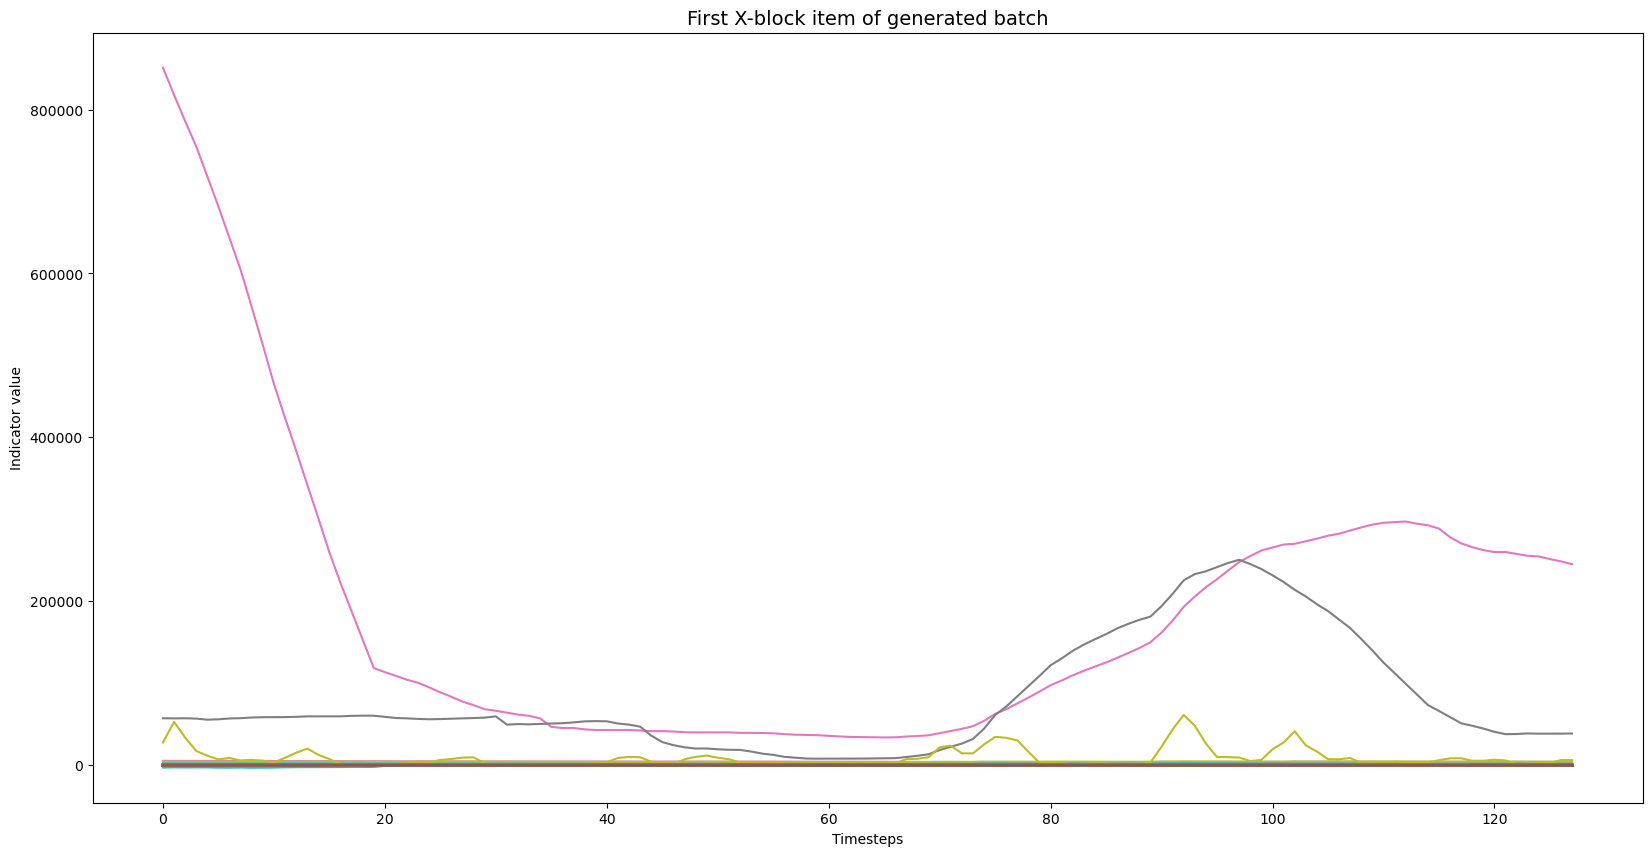

In [82]:
# Plot the first X-Block
chart_name="First X-block item of generated batch"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(XT)

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Indicator value")

# Save the figure
fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

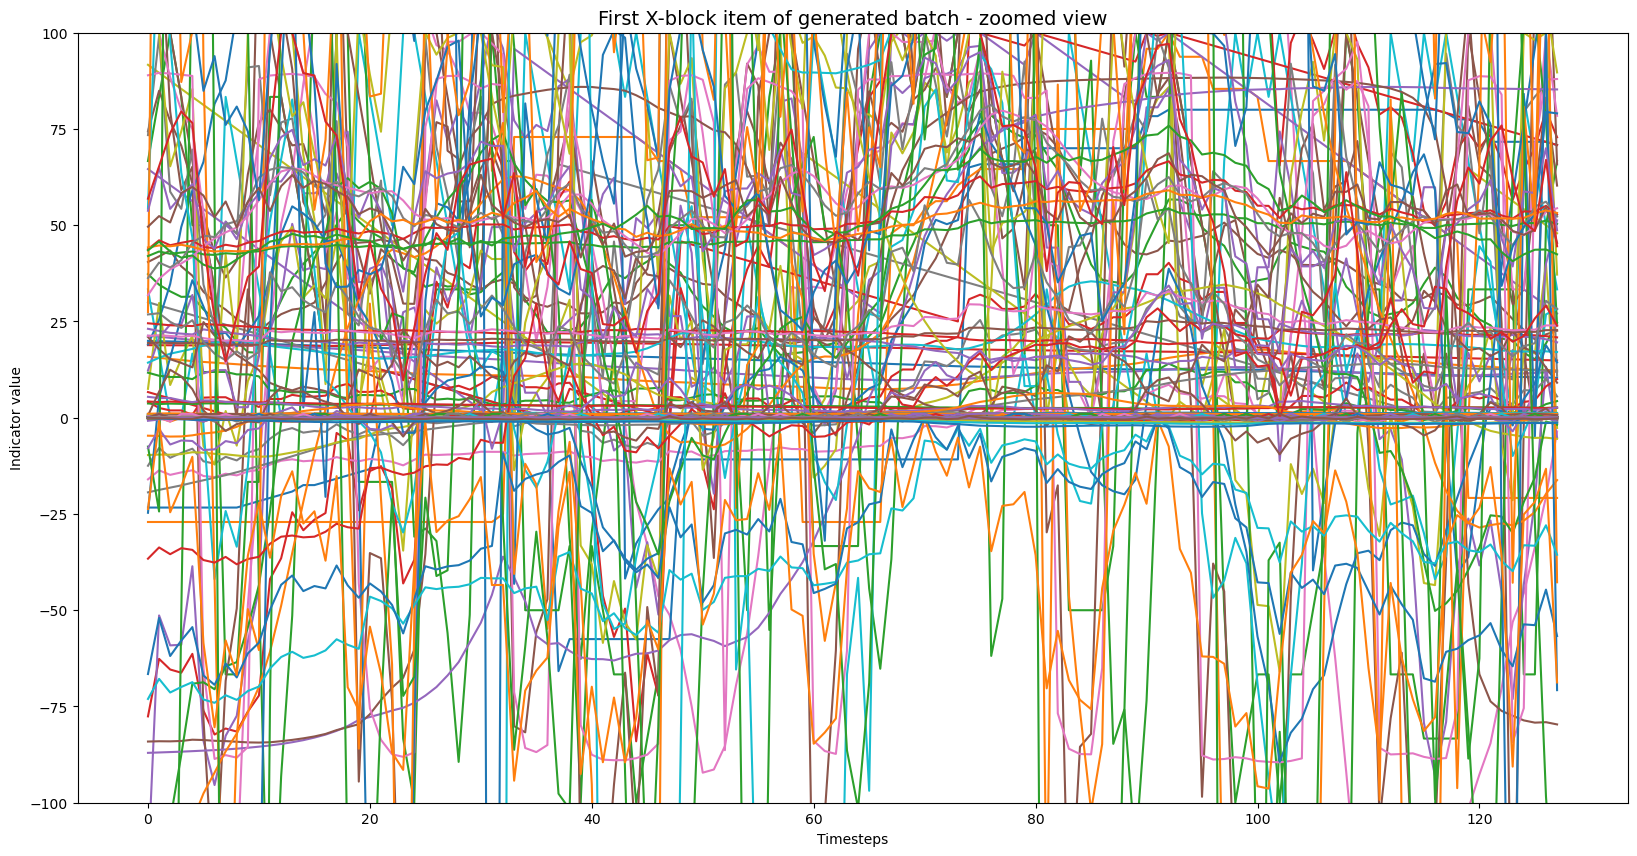

In [83]:
# Plot the first X-Block
chart_name="First X-block item of generated batch - zoomed view"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(XT)

ax1.set_ylim(-100,100)

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Indicator value")

# Save the figure
fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

---
## Combine the XT data and the yT direction information

In [84]:
y = batchLatest['y']
y

array([[ 0.80104011, -0.00827966],
       [ 0.79684097, -0.00856637],
       [ 0.79268774, -0.00884668],
       [ 0.78815006, -0.00909578],
       [ 0.78420974, -0.00935088],
       [ 0.78020722, -0.00959125],
       [ 0.77861253, -0.00989064],
       [ 0.77493211, -0.01019207],
       [ 0.77100019, -0.01052337],
       [ 0.76597368, -0.01085411],
       [ 0.76065844, -0.01117252],
       [ 0.75566595, -0.01147169],
       [ 0.74980847, -0.01185083],
       [ 0.74320089, -0.01222548],
       [ 0.73467381, -0.01264053],
       [ 0.72585294, -0.01301183],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [85]:
yT = y[0,:]
yT

array([ 0.80104011, -0.00827966])

In [86]:
trainDataPoint = {"X":XT, "y":yT}
trainDataPoint

{'X': array([[ 1.99633105e+01,  1.58279204e+01,  3.73126596e+01, ...,
          5.68943612e+01,  0.00000000e+00,  0.00000000e+00],
        [ 1.98877793e+01,  1.55510607e+01,  3.45518213e+01, ...,
          6.52856925e+01, -2.12502965e-03, -1.32224616e-01],
        [ 1.98102625e+01,  1.52666845e+01,  3.28294503e+01, ...,
          7.39027164e+01, -5.43176891e-05, -1.42536019e-01],
        ...,
        [ 1.04777356e+01,  1.24543163e+01,  1.51635884e+01, ...,
          4.84943336e+01,  8.27744338e-04, -3.81800303e-01],
        [ 1.04198458e+01,  1.23645479e+01,  1.93021711e+01, ...,
          6.69531965e+01, -3.10785550e-04, -3.19496891e-01],
        [ 1.03689825e+01,  1.23157829e+01,  2.46314650e+01, ...,
          4.45333509e+01,  1.63910737e-03, -1.65471712e-01]]),
 'y': array([ 0.80104011, -0.00827966])}

## Conclusion

The information in `trainDataPoint` can be understood as looking a hourly tick and indicator chart zoomed to 128 hours (`X`), while having the information how the price direction (and its derivation) will be in the future (`y`). In the example above, the price will rise, as the direction is `0.8010`.

This method can be performed on a big dataset, like historical crypto data, to generate a very large amount of training data to create a neural network, which then may be able to predict the `y` future information on live tick data.

Beware that the link between the loaded .csv file and X/y data may be complicated, as some elements in the beginning and end may be cropped to provide lookback/lookahead, also the data generator can be shuffled, to mix up several currencies at different timestamps.